## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (CURRENT_YEAR defined in utils.py)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-06-08 05:06:08.399735


{1: 24.4,
 5: 25.7,
 10: 26.4,
 20: 27.4,
 30: 28.9,
 40: 30.6,
 50: 32.3,
 60: 34.1,
 70: 36.1,
 80: 38.6,
 90: 41.9,
 95: 45.004999999999924,
 99: 50.8}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2024-06-08 05:48:27.404261


{1: 8.1,
 5: 8.3,
 10: 8.4,
 20: 8.6,
 30: 8.7,
 40: 8.8,
 50: 8.9,
 60: 9.0,
 70: 9.1,
 80: 9.3,
 90: 9.5,
 95: 9.7,
 99: 10.1}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2024-06-08 05:46:58.259120


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev1)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=7.56, lognorm_sd=3.93, norm_mean=1.9, norm_sd=0.49) (version 0.28-dev1)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev1)}}

In [6]:
def wildeford_max_gdp_frac():
    gdp_frac = sq.mixture([[0.5, sq.lognorm(1/500, 1/100)],
                           [0.5, sq.lognorm(1/500, 1/20)]])
    percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
    percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)
    compute_frac = gdp_frac * percent_spent_on_compute * percent_spent_on_largest_model
    return {'total_frac': gdp_frac, 'compute_frac': compute_frac}


base_flop_per_dollar = sq.norm(18.2, 19.4) # https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
# I'd use 1.43e18 FLOP/$ if renting cloud compute for training (significantly higher for serving a product, and significantly lower if using your own compute -- but then the number depends on how long you amortize it over).
# Source: If renting cloud compute, pricing seems to be $1.89-2.40 per H100 hour. (Jack Clark says $2 with bulk discounts.) Going with $2/hr, with the H100's 1.98e15 FLOP/s (FP8) and assuming 40% utilization (for training), that's 1.98e15*.4*60*60/2 = 1.43e18 FLOP/$.
# https://jack-clark.net/2024/03/28/what-does-1025-versus-1026-mean/ and https://gpus.llm-utils.org/h100-gpu-cloud-availability-and-pricing/
flop_frontier_penalty = 0 # sq.norm(0, 1)

# https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': sq.lognorm(0.75, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': base_flop_per_dollar - flop_frontier_penalty,
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'],
             'spend_doubling_time': sq.lognorm(0.5, 2, lclip=0.1),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

#### Total % of GDP spent on entire project

In [7]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 19793.83it/s]


{1: 0.00122,
 5: 0.00204,
 10: 0.00253,
 20: 0.0034,
 30: 0.00416,
 40: 0.00498,
 50: 0.00594,
 60: 0.00722,
 70: 0.00914,
 80: 0.01289,
 90: 0.02258,
 95: 0.03355,
 99: 0.07735}

In [8]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.122%',
 5: '0.204%',
 10: '0.253%',
 20: '0.34%',
 30: '0.416%',
 40: '0.498%',
 50: '0.594%',
 60: '0.722%',
 70: '0.914%',
 80: '1.289%',
 90: '2.258%',
 95: '3.355%',
 99: '7.735%'}

In [9]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '30.7 billion',
 5: '51.2 billion',
 10: '63.4 billion',
 20: '85.4 billion',
 30: '104.5 billion',
 40: '125.2 billion',
 50: '149.3 billion',
 60: '181.3 billion',
 70: '230.2 billion',
 80: '324.0 billion',
 90: '567.2 billion',
 95: '844.2 billion',
 99: '1.9 trillion'}

#### Total GDP spent on compute for largest model

In [10]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 6386.29it/s]


{1: 1e-05,
 5: 4e-05,
 10: 7e-05,
 20: 0.00013,
 30: 0.00022,
 40: 0.00032,
 50: 0.00049,
 60: 0.00072,
 70: 0.00113,
 80: 0.00189,
 90: 0.00372,
 95: 0.00659,
 99: 0.01744}

In [11]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.001%',
 5: '0.004%',
 10: '0.007%',
 20: '0.013%',
 30: '0.022%',
 40: '0.032%',
 50: '0.049%',
 60: '0.072%',
 70: '0.113%',
 80: '0.189%',
 90: '0.372%',
 95: '0.659%',
 99: '1.744%'}

In [12]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '348.7 million',
 5: '948.1 million',
 10: '1.7 billion',
 20: '3.3 billion',
 30: '5.4 billion',
 40: '8.2 billion',
 50: '12.2 billion',
 60: '18.1 billion',
 70: '28.3 billion',
 80: '47.5 billion',
 90: '93.4 billion',
 95: '166.0 billion',
 99: '439.7 billion'}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 38.2 log FLOP (~158.5 thousand decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.8 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~22.9 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.3 billion).
* This doubles every 0.8 year to a max of 0.024218% of GDP (initially ~6.1 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 38.2 logFLOP which costs 19.8 log 2025$USD to buy vs. WTP at 9.0 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 37.9 logFLOP which costs 19.4 log 2025$USD to buy vs. WTP at 9.3 (buys 27.9 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 37.7 logFLOP which costs 19.0 log 2025$USD to buy vs. WTP at 9.5 (buys 28.2 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 37.4 logFLOP which 

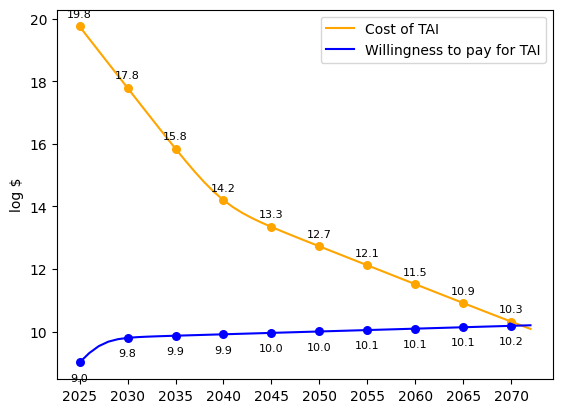



## SAMPLE RUN 2 ##

In this simulation:
* It takes 30.8 log FLOP (~6.3 nonillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~11.1 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~7.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~313.3 million).
* This doubles every 1.2 year to a max of 0.136708% of GDP (initially ~34.1 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 30.8 logFLOP which costs 11.8 log 2025$USD to buy vs. WTP at 8.5 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 30.5 logFLOP which costs 11.3 log 2025$USD to buy vs. WTP at 8.7 (buys 27.9 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 30.3 logFLOP which costs 10.9 log 2025$USD to buy vs. WTP at 9.0 (buys 28.3 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 30.0 logFLOP which costs 10

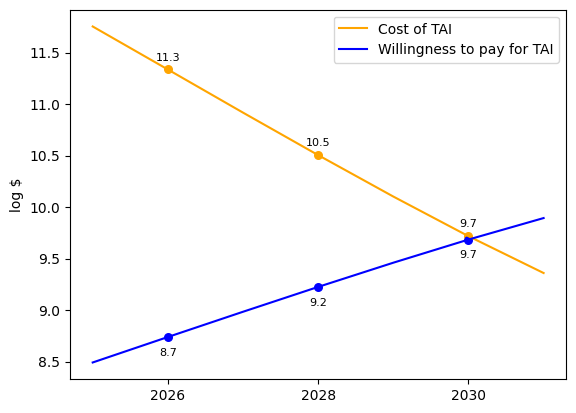



## SAMPLE RUN 3 ##

In this simulation:
* It takes 34.5 log FLOP (~31.6 decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.4 log FLOP (~24.1 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 25.7 log FLOP (~47.8 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~590.4 million).
* This doubles every 0.9 year to a max of 0.036598% of GDP (initially ~9.2 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 34.5 logFLOP which costs 15.1 log 2025$USD to buy vs. WTP at 8.7 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 34.0 logFLOP which costs 14.5 log 2025$USD to buy vs. WTP at 9.1 (buys 28.6 log FLOP or 29.1 2025-log-eFLOP)
2027 - TAI takes 33.5 logFLOP which costs 13.9 log 2025$USD to buy vs. WTP at 9.3 (buys 29.0 log FLOP or 30.0 2025-log-eFLOP)
2028 - TAI takes 33.0 logFLOP which costs 1

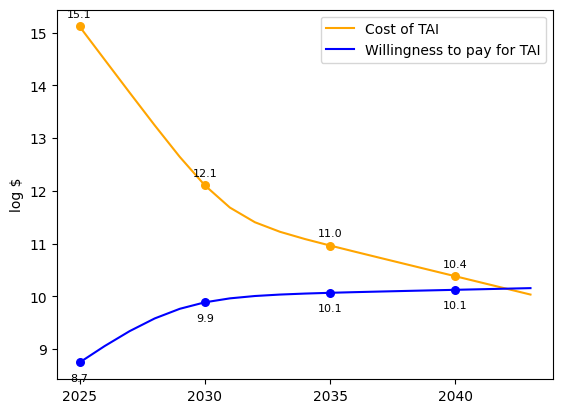



## RUN TIMELINES MODEL ##
Generating Bayes net with 12 cores...


10044it [00:14, 669.89it/s]                                                                                                                                                                                                                          


Shuffling data...
Writing data...
Waiting for other cores...
...Collecting data...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1067.23it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!

## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2029',
 '10%: 2030',
 '15%: 2031',
 '20%: 2033',
 '25%: 2033',
 '35%: 2036',
 '50%: 2041',
 '60%: 2047',
 '75%: 2078',
 '80%: >2125',
 '90%: >2125',
 '95%: >2125']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 4 years from now',
 '10%: 5 years from now',
 '15%: 6 years from now',
 '20%: 8 years from now',
 '25%: 8 years from now',
 '35%: 11 years from now',
 '50%: 16 years from now',
 '60%: 22 years from now',
 '75%: 53 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 35 years from now)


## TAI ARRIVAL DATE BY BIN ##
2025-2026: 1.9%
2027-2029: 5.3%
2030-2034: 23.5%
2035-2039: 16.4%
2040-2049: 15.2%
2050-2059: 7.8%
2060-2069: 3.1%
2070-2079: 2.0%
2080-2089: 1.0%
2090-2099: 0.4%
2100-2109: 1.0%
2110-2119: 0.5%
>2125: 21.9%


##



## GDP Over Time ##
Year: 2025 - GDP log 2024$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2026 - GDP log 2024$USD 13.4 (~25.7 trillion) 80% CI 13.4 (~25.4 trillion) - 13.4 (~26.0 trillion)
Year: 2027 - GDP log 2024$USD 13.4 (~26.3 trillion) 80% CI 13.4 (~25.8 trillion) - 13.4 (~26.7 trillion)
Year: 2028 - GDP log 2024$USD 13.4 (~26.9 trillion) 80% CI 13.4 (~26.2 trillion) - 13.4 (~27.5 trillion)
Year: 2029 - GDP log 2024$USD 13.4 (~27.5 trillion) 80% CI 13.4 (~26.6 trillion) - 13.5 (~28.2 trillion)
Year: 2030 - GDP log 2024$USD 13.4 (~28.1 trillion) 80% CI 13.4 (~27.0 trillion) - 13.5 (~29.1 trillion)
Year: 2031 - GDP log 2024$USD 13.5 (~28.7 trillion) 80% CI 13.4 (~27.5 trillion) - 13.5 (~29.9 trillion)
Year: 2032 - GDP log 2024$USD 13.5 (~29.4 trillion) 80% CI 13.4 (~27.9 trillion) - 13.5 (~30.7 trillion)
Year: 2033 - GDP log 2024$USD 13.5 (~30.0 trillion) 80% CI 13.5 (~28.3 trillion) - 13.5 (~31.6 trillion)
Year: 2034 - GDP log 2024$USD 13.

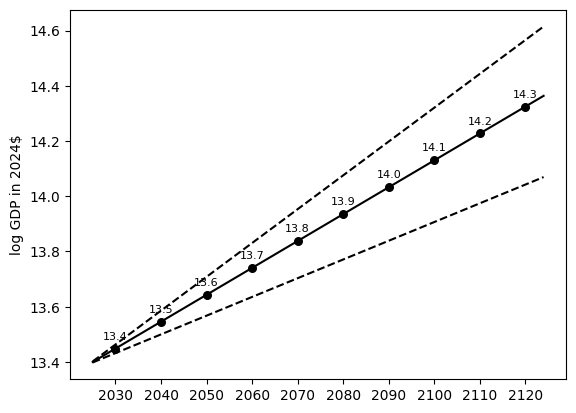

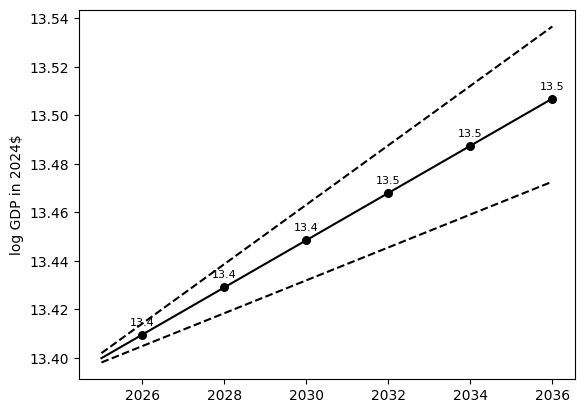



## Willingness to Pay Over Time ##
Year: 2025 - willingness log 2024$USD per year 8.9 (~748.6 million) 80% CI 8.6 (~355.9 million) - 9.3 (~1.9 billion)
Year: 2026 - willingness log 2024$USD per year 9.2 (~1.4 billion) 80% CI 8.9 (~814.8 million) - 9.5 (~3.1 billion)
Year: 2027 - willingness log 2024$USD per year 9.4 (~2.6 billion) 80% CI 9.2 (~1.6 billion) - 9.7 (~4.8 billion)
Year: 2028 - willingness log 2024$USD per year 9.6 (~4.4 billion) 80% CI 9.4 (~2.4 billion) - 9.9 (~7.5 billion)
Year: 2029 - willingness log 2024$USD per year 9.8 (~6.8 billion) 80% CI 9.5 (~3.1 billion) - 10.1 (~11.3 billion)
Year: 2030 - willingness log 2024$USD per year 10.0 (~9.3 billion) 80% CI 9.5 (~3.4 billion) - 10.2 (~16.4 billion)
Year: 2031 - willingness log 2024$USD per year 10.1 (~11.5 billion) 80% CI 9.6 (~3.6 billion) - 10.4 (~22.8 billion)
Year: 2032 - willingness log 2024$USD per year 10.1 (~13.3 billion) 80% CI 9.6 (~3.7 billion) - 10.5 (~30.2 billion)
Year: 2033 - willingness log 2024$USD pe

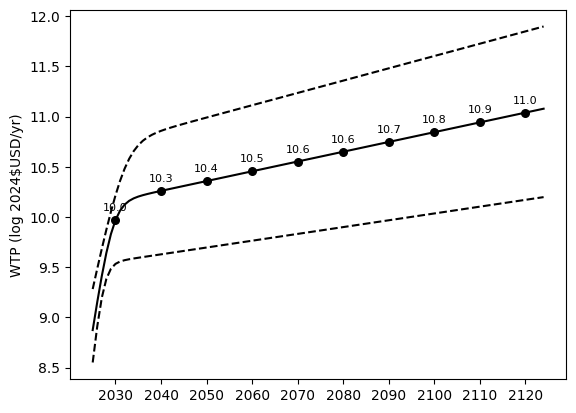

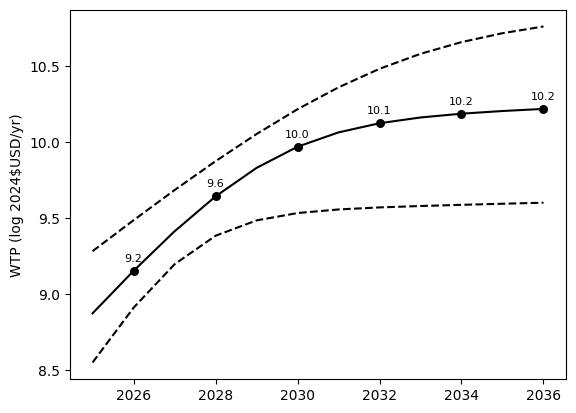



## Actual FLOP Needed to Make TAI (Given Algorithmic Progress) ##
Year: 2025 - logFLOP needed for TAI 32.7 (~446.7 nonillion) 80% CI 27.4 (~2.5 octillion) - 38.6 (~398.1 thousand decillion)
Year: 2026 - logFLOP needed for TAI 32.4 (~224.2 nonillion) 80% CI 27.1 (~1.3 octillion) - 38.4 (~238.4 thousand decillion)
Year: 2027 - logFLOP needed for TAI 32.1 (~112.6 nonillion) 80% CI 26.8 (~705.1 septillion) - 38.2 (~142.8 thousand decillion)
Year: 2028 - logFLOP needed for TAI 31.8 (~57.6 nonillion) 80% CI 26.6 (~378.9 septillion) - 37.9 (~85.5 thousand decillion)
Year: 2029 - logFLOP needed for TAI 31.5 (~30.6 nonillion) 80% CI 26.3 (~209.2 septillion) - 37.7 (~51.2 thousand decillion)
Year: 2030 - logFLOP needed for TAI 31.2 (~17.3 nonillion) 80% CI 26.1 (~120.9 septillion) - 37.5 (~30.7 thousand decillion)
Year: 2031 - logFLOP needed for TAI 31.0 (~10.8 nonillion) 80% CI 25.9 (~75.0 septillion) - 37.3 (~18.4 thousand decillion)
Year: 2032 - logFLOP needed for TAI 30.9 (~7.6 nonillion) 

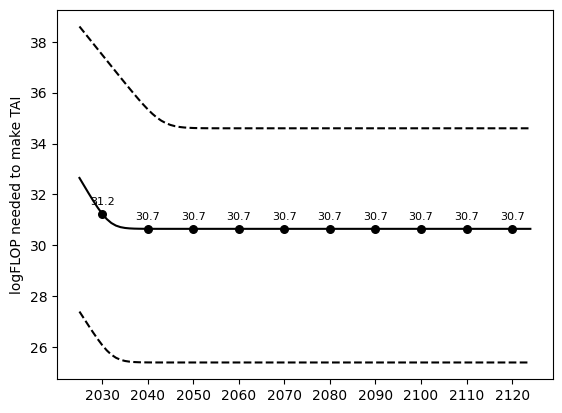

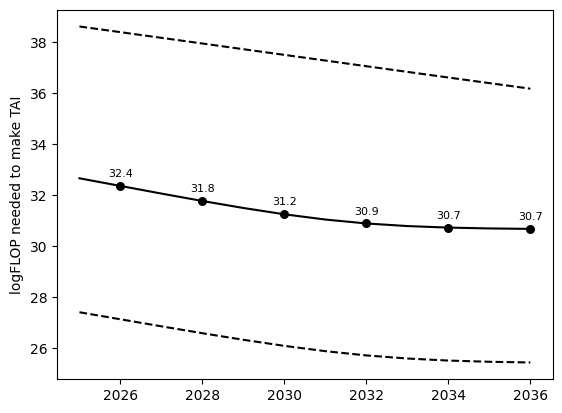



## FLOP per Dollar (Given Declining Costs) ##
Year: 2025 - logFLOP per 2024$1USD 18.8 (~6.3 quintillion) 80% CI 18.5 (~3.1 quintillion) - 19.1 (~12.5 quintillion)
Year: 2026 - logFLOP per 2024$1USD 18.9 (~8.3 quintillion) 80% CI 18.6 (~4.2 quintillion) - 19.2 (~16.1 quintillion)
Year: 2027 - logFLOP per 2024$1USD 19.0 (~11.0 quintillion) 80% CI 18.8 (~5.7 quintillion) - 19.3 (~20.7 quintillion)
Year: 2028 - logFLOP per 2024$1USD 19.2 (~14.5 quintillion) 80% CI 18.9 (~7.8 quintillion) - 19.4 (~26.6 quintillion)
Year: 2029 - logFLOP per 2024$1USD 19.3 (~19.2 quintillion) 80% CI 19.0 (~10.7 quintillion) - 19.5 (~34.3 quintillion)
Year: 2030 - logFLOP per 2024$1USD 19.4 (~25.4 quintillion) 80% CI 19.2 (~14.5 quintillion) - 19.6 (~44.0 quintillion)
Year: 2031 - logFLOP per 2024$1USD 19.5 (~33.5 quintillion) 80% CI 19.3 (~19.8 quintillion) - 19.8 (~56.6 quintillion)
Year: 2032 - logFLOP per 2024$1USD 19.6 (~44.3 quintillion) 80% CI 19.4 (~27.0 quintillion) - 19.9 (~72.8 quintillion)
Year: 

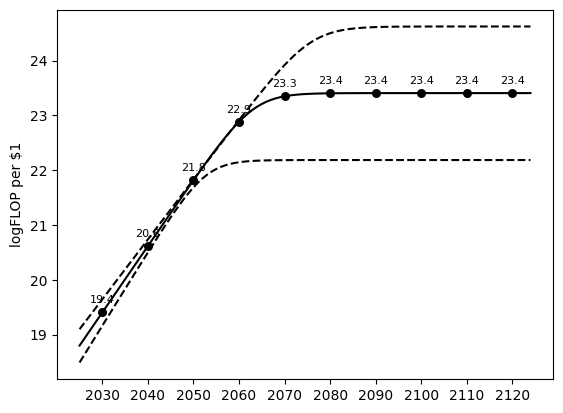

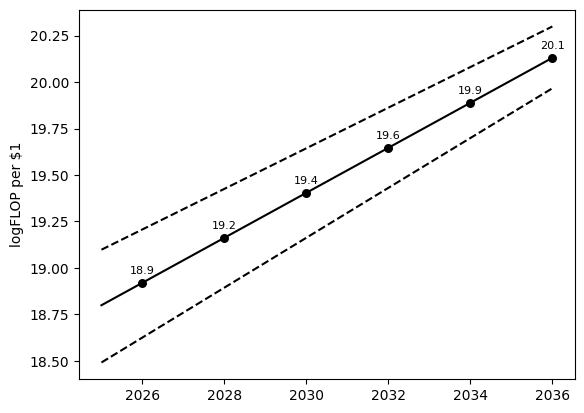



## Max Possible OOM Reduction in TAI FLOP Size ##
TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2

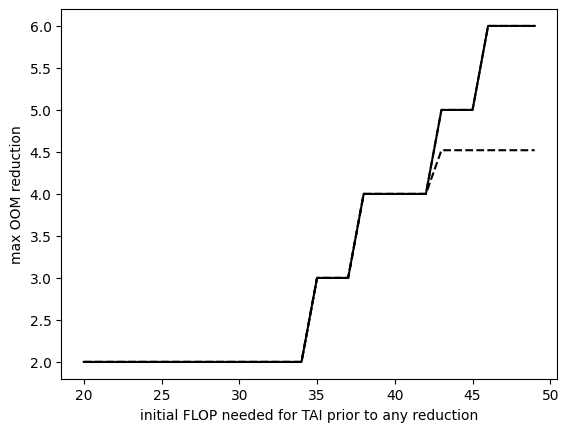



## Halving time (years) of compute requirements ##
TAI log FLOP 20 -> algo doubling rate 1.51yrs (80% CI: 2.19 to 2.19)
TAI log FLOP 21 -> algo doubling rate 1.51yrs (80% CI: 2.19 to 2.19)
TAI log FLOP 22 -> algo doubling rate 1.51yrs (80% CI: 2.19 to 2.19)
TAI log FLOP 23 -> algo doubling rate 1.51yrs (80% CI: 2.19 to 2.19)
TAI log FLOP 24 -> algo doubling rate 1.51yrs (80% CI: 2.19 to 2.19)
TAI log FLOP 25 -> algo doubling rate 1.51yrs (80% CI: 2.19 to 2.19)
TAI log FLOP 26 -> algo doubling rate 1.51yrs (80% CI: 2.19 to 2.19)
TAI log FLOP 27 -> algo doubling rate 1.51yrs (80% CI: 2.19 to 2.19)
TAI log FLOP 28 -> algo doubling rate 1.51yrs (80% CI: 2.19 to 2.19)
TAI log FLOP 29 -> algo doubling rate 1.51yrs (80% CI: 2.19 to 2.19)
TAI log FLOP 30 -> algo doubling rate 1.51yrs (80% CI: 2.19 to 2.19)
TAI log FLOP 31 -> algo doubling rate 1.01yrs (80% CI: 1.69 to 1.69)
TAI log FLOP 32 -> algo doubling rate 0.98yrs (80% CI: 1.19 to 1.19)
TAI log FLOP 33 -> algo doubling rate 0.98yrs (80%

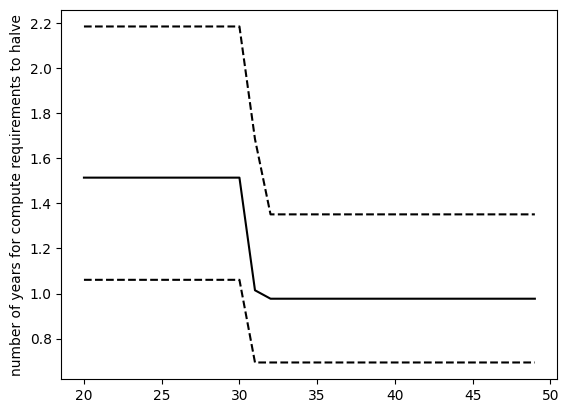



## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP) ##
Year: 2025 - 13.9 log 2024$USD to buy TAI (~71.0 trillion) 80% CI 8.9 (~811.7 million) - 19.5 (~31.8 quintillion)
Year: 2026 - 13.4 log 2024$USD to buy TAI (~27.0 trillion) 80% CI 8.5 (~315.9 million) - 19.2 (~14.8 quintillion)
Year: 2027 - 13.0 log 2024$USD to buy TAI (~10.2 trillion) 80% CI 8.1 (~122.7 million) - 18.8 (~6.9 quintillion)
Year: 2028 - 12.6 log 2024$USD to buy TAI (~4.0 trillion) 80% CI 7.7 (~48.4 million) - 18.5 (~3.2 quintillion)
Year: 2029 - 12.2 log 2024$USD to buy TAI (~1.6 trillion) 80% CI 7.3 (~19.6 million) - 18.2 (~1.5 quintillion)
Year: 2030 - 11.8 log 2024$USD to buy TAI (~683.5 billion) 80% CI 6.9 (~8.3 million) - 17.8 (~696.6 quadrillion)
Year: 2031 - 11.5 log 2024$USD to buy TAI (~322.1 billion) 80% CI 6.6 (~3.8 million) - 17.5 (~324.6 quadrillion)
Year: 2032 - 11.2 log 2024$USD to buy TAI (~171.1 billion) 80% CI 6.3 (~1.9 million) - 17.2 (~151.4 quadrillion)
Year: 

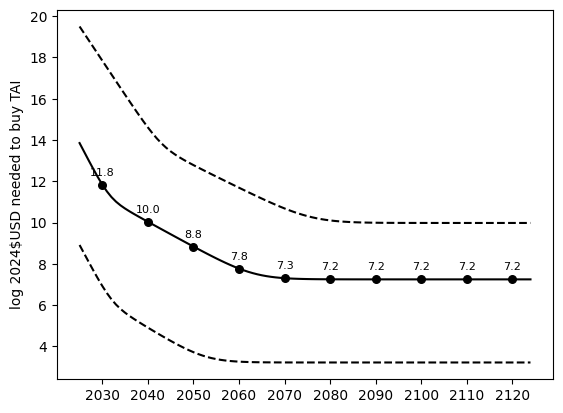

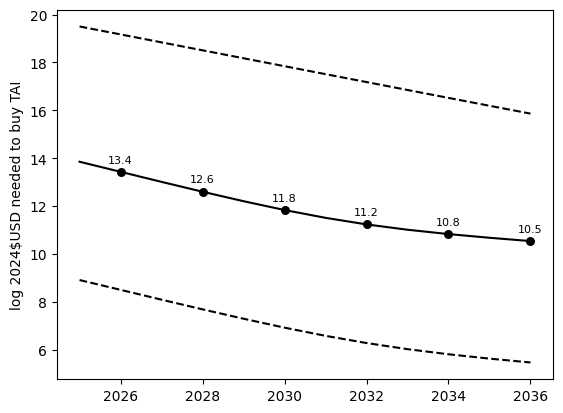



## Actual FLOP at Max Spend ##
Year: 2025 - max log FLOP 27.7 (~4.7 octillion) 80% CI 27.0 (~1.1 octillion) - 28.4 (~24.0 octillion)
Year: 2026 - max log FLOP 28.1 (~11.8 octillion) 80% CI 27.5 (~3.4 octillion) - 28.7 (~49.3 octillion)
Year: 2027 - max log FLOP 28.5 (~28.4 octillion) 80% CI 28.0 (~9.0 octillion) - 29.0 (~99.9 octillion)
Year: 2028 - max log FLOP 28.8 (~63.7 octillion) 80% CI 28.3 (~18.9 octillion) - 29.3 (~198.9 octillion)
Year: 2029 - max log FLOP 29.1 (~129.6 octillion) 80% CI 28.5 (~32.5 octillion) - 29.6 (~385.8 octillion)
Year: 2030 - max log FLOP 29.4 (~235.8 octillion) 80% CI 28.7 (~49.6 octillion) - 29.9 (~722.2 octillion)
Year: 2031 - max log FLOP 29.6 (~387.1 octillion) 80% CI 28.9 (~71.3 octillion) - 30.1 (~1.3 nonillion)
Year: 2032 - max log FLOP 29.8 (~587.5 octillion) 80% CI 29.0 (~100.1 octillion) - 30.3 (~2.2 nonillion)
Year: 2033 - max log FLOP 29.9 (~847.2 octillion) 80% CI 29.1 (~139.3 octillion) - 30.6 (~3.6 nonillion)
Year: 2034 - max log FLOP 30

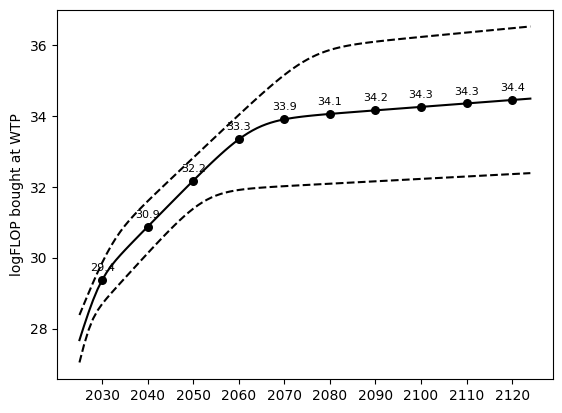

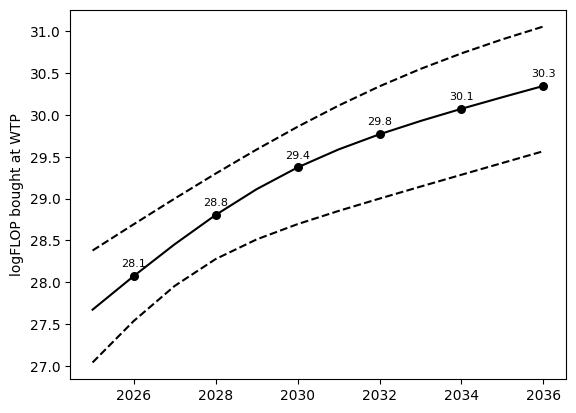



## Effective 2024-FLOP at Max Spend (given algorithmic progress and decline in $/FLOP) ##
Year: 2025 - max log effective 2024-FLOP 27.7 (~4.7 octillion) 80% CI 27.0 (~1.1 octillion) - 28.4 (~24.0 octillion)
Year: 2026 - max log effective 2024-FLOP 28.4 (~23.6 octillion) 80% CI 27.8 (~5.6 octillion) - 29.1 (~133.7 octillion)
Year: 2027 - max log effective 2024-FLOP 29.1 (~112.8 octillion) 80% CI 28.4 (~24.5 octillion) - 29.9 (~736.0 octillion)
Year: 2028 - max log effective 2024-FLOP 29.7 (~493.6 octillion) 80% CI 28.9 (~84.3 octillion) - 30.6 (~4.0 nonillion)
Year: 2029 - max log effective 2024-FLOP 30.3 (~1.9 nonillion) 80% CI 29.4 (~234.9 octillion) - 31.3 (~20.8 nonillion)
Year: 2030 - max log effective 2024-FLOP 30.8 (~6.1 nonillion) 80% CI 29.8 (~569.9 octillion) - 32.0 (~105.0 nonillion)
Year: 2031 - max log effective 2024-FLOP 31.2 (~16.0 nonillion) 80% CI 30.1 (~1.3 nonillion) - 32.7 (~497.8 nonillion)
Year: 2032 - max log effective 2024-FLOP 31.5 (~34.6 nonillion) 80% CI 30.

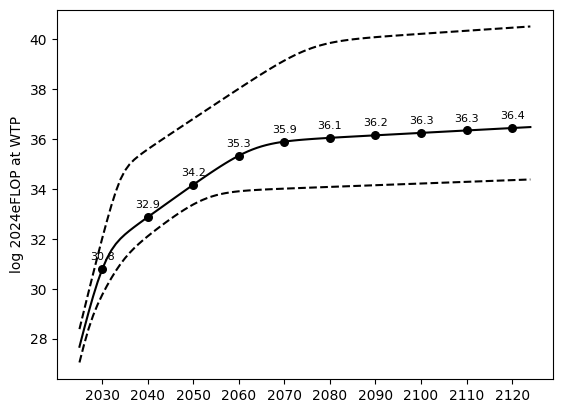

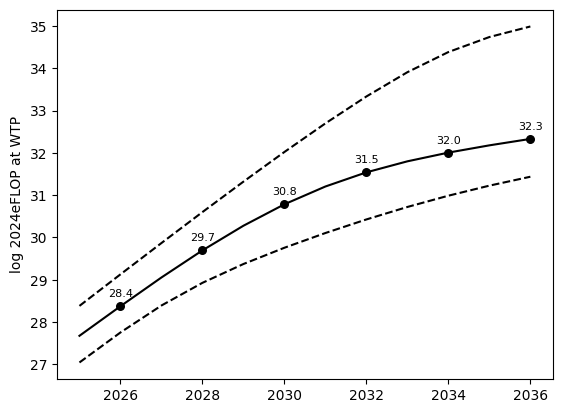


## TAI FLOP SIZE ##
{1: 24.0,
 5: 25.7,
 10: 26.3,
 20: 27.4,
 30: 29.0,
 40: 30.7,
 50: 32.650000000000006,
 60: 34.1,
 70: 36.23,
 80: 38.6,
 90: 42.010000000000005,
 95: 45.3,
 99: 51.300999999999995}


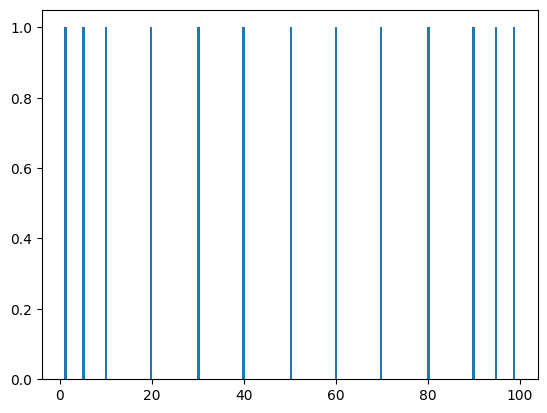



## MIN REDUCTION: 2 ##

## MAX REDUCTION ##
{1: 2.2322507137059184,
 5: 3.0567437358925735,
 10: 3.676140699657302,
 20: 4.520185046963153,
 30: 5.1367757956995606,
 40: 5.84932940302373,
 50: 6.665478956255784,
 60: 7.5680088183617285,
 70: 8.675569655577188,
 80: 10.261493915716157,
 90: 12.690428486477751,
 95: 15.394444506860665,
 99: 21.481380218057605}


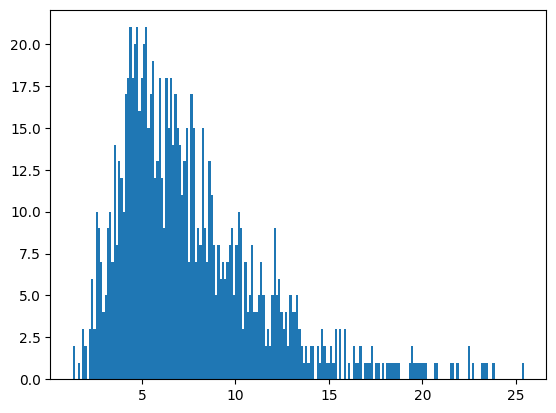



## MIN ALGO DOUBLING RATE ##
{1: 0.38781567342650985,
 5: 0.5061243129223169,
 10: 0.5729602223592051,
 20: 0.6940166295808388,
 30: 0.7906841437218505,
 40: 0.8771304998501633,
 50: 0.9770755718222436,
 60: 1.0839055557831039,
 70: 1.2064101084067815,
 80: 1.3514976656709403,
 90: 1.6771262552213981,
 95: 1.9561093131718987,
 99: 2.5113332980932785}


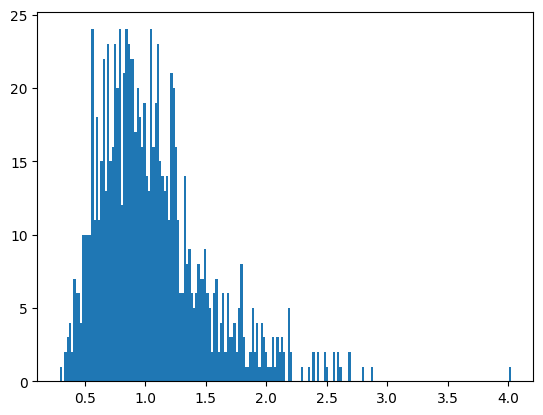



## MAX ALGO DOUBLING RATE ##
{1: 0.577504974386434,
 5: 0.7663880278163723,
 10: 0.886394913756043,
 20: 1.0609289638177704,
 30: 1.222246771335903,
 40: 1.3655529956987604,
 50: 1.5145348501582863,
 60: 1.6859377294037683,
 70: 1.9024991229311499,
 80: 2.1855582372837694,
 90: 2.5433535009110364,
 95: 2.901548432457516,
 99: 4.096371041338789}


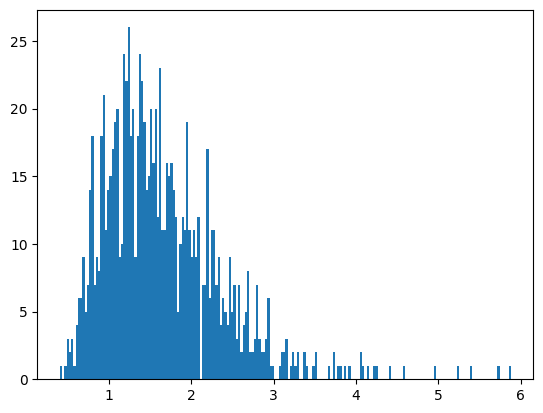



## INITIAL FLOP PER DOLLAR ##
{1: 17.99772423525278,
 5: 18.196529899922584,
 10: 18.323236915744065,
 20: 18.490708963102104,
 30: 18.60537409491534,
 40: 18.700089263201463,
 50: 18.798789441761635,
 60: 18.901017098634824,
 70: 18.997512625034975,
 80: 19.097682985642,
 90: 19.247695038108585,
 95: 19.368696741308458,
 99: 19.574192263989048}


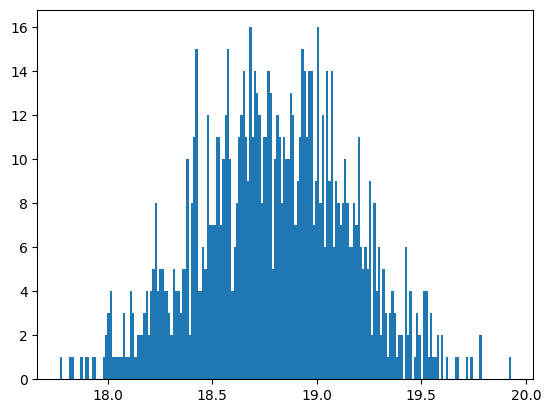



## FLOP HALVING RATE ##
{1: 1.8154579689898729,
 5: 2.0196009074782237,
 10: 2.112862035691637,
 20: 2.239764525263479,
 30: 2.3451128446365734,
 40: 2.4179436144532818,
 50: 2.4858972966465216,
 60: 2.5615903808690996,
 70: 2.661551727453322,
 80: 2.7554813268742335,
 90: 2.87669670752889,
 95: 2.993774880022868,
 99: 3.1707391666076554}


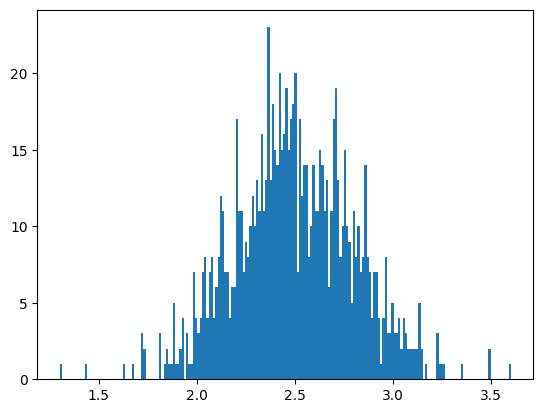



## MAX FLOP PER DOLLAR ##
{1: 19.661933914863262,
 5: 21.01188854691905,
 10: 21.54223411443042,
 20: 22.184998644336975,
 30: 22.64034125092296,
 40: 23.03857707065686,
 50: 23.406534157684696,
 60: 23.77373915387718,
 70: 24.176541534683416,
 80: 24.622234870302922,
 90: 25.23545536269116,
 95: 26.018683982973076,
 99: 27.13080432772899}


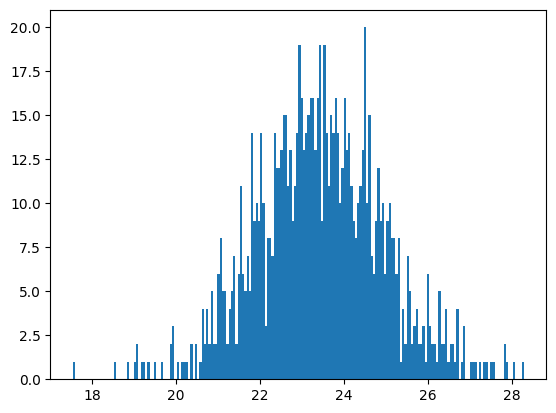



## INITIAL PAY ##
{1: 8.199,
 5: 8.3,
 10: 8.4,
 20: 8.6,
 30: 8.7,
 40: 8.8,
 50: 8.9,
 60: 9.0,
 70: 9.1,
 80: 9.3,
 90: 9.6,
 95: 9.8,
 99: 10.1}


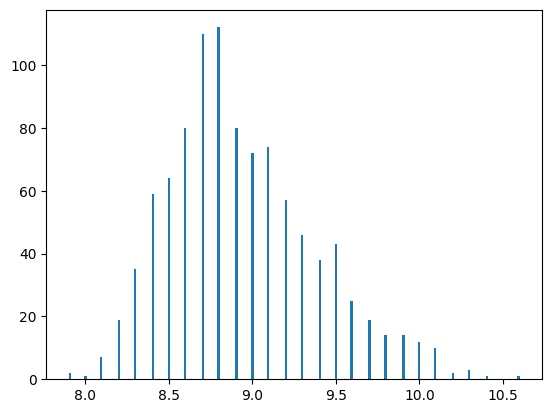



## INITIAL GDP ##
{1: 24828892927488.02,
 5: 24903309656780.242,
 10: 24948698360921.176,
 20: 25007882091277.363,
 30: 25046715283462.812,
 40: 25079506350272.008,
 50: 25110812640203.22,
 60: 25145456092507.37,
 70: 25188468218386.16,
 80: 25230423153568.375,
 90: 25285839052261.848,
 95: 25330883591464.605,
 99: 25424424074668.42}


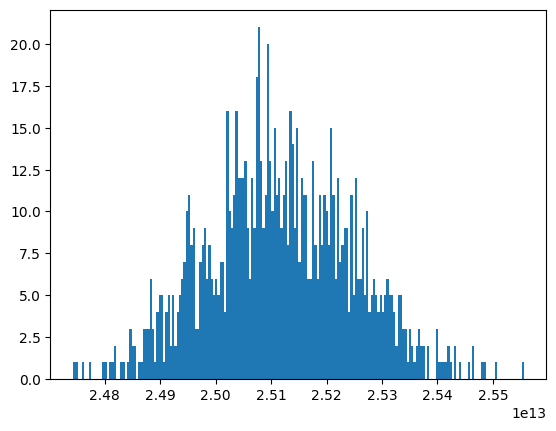



## GDP GROWTH ##
{1: 1.005,
 5: 1.0093712470817613,
 10: 1.0125878562570838,
 20: 1.0157391406293417,
 30: 1.0184494402130713,
 40: 1.020566318882364,
 50: 1.0226714807927029,
 60: 1.0244216725762016,
 70: 1.026202614527972,
 80: 1.0286138791933206,
 90: 1.0321137273136705,
 95: 1.0348195123261708,
 99: 1.0394500863319798}


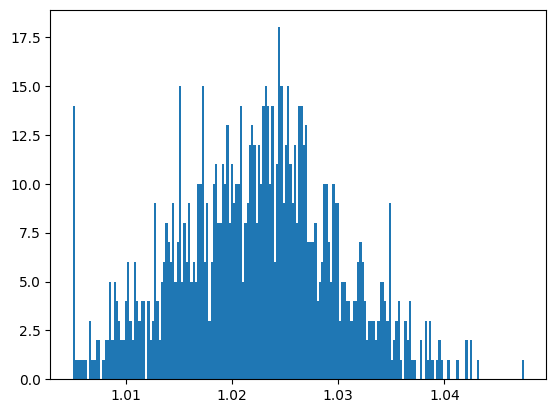



## MAX GDP FRAC ##
{1: 1.6448349090740502e-05,
 5: 4.0103424017696394e-05,
 10: 6.124388455988179e-05,
 20: 0.00013432741929758927,
 30: 0.0002153476772586517,
 40: 0.00032749599270546944,
 50: 0.0005177285160357708,
 60: 0.0007719540927332912,
 70: 0.0011429047647035916,
 80: 0.00191232918246037,
 90: 0.003832564396287844,
 95: 0.007802767715779008,
 99: 0.01785570899664877}


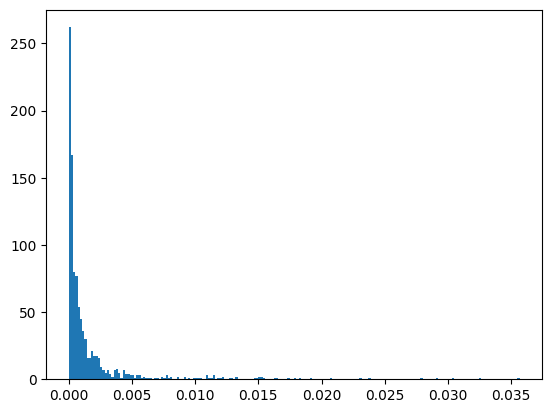



## SPEND DOUBLING TIME ##
{1: 0.36443756128540766,
 5: 0.5029640725214405,
 10: 0.5844481488901415,
 20: 0.7008468211797064,
 30: 0.8036700465933097,
 40: 0.89983724472998,
 50: 0.9960373935955678,
 60: 1.1227201028196367,
 70: 1.2375062665500747,
 80: 1.4111825624204541,
 90: 1.6765699460931747,
 95: 1.981046237371782,
 99: 2.510197200556466}


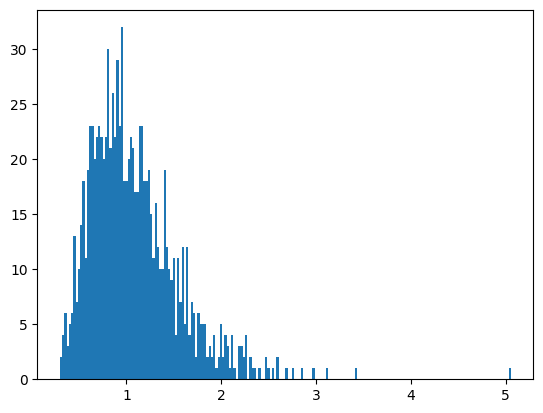





## Nonscaling delay ##
There are 3 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> mixture
 - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
 - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) years if it happens
{1: 2,
 5: 2,
 10: 2,
 20: 3,
 30: 3,
 40: 3,
 50: 3,
 60: 4,
 70: 4,
 80: 4,
 90: 5,
 95: 7,
 99: 16}
## Chance of nonscaling delay ##


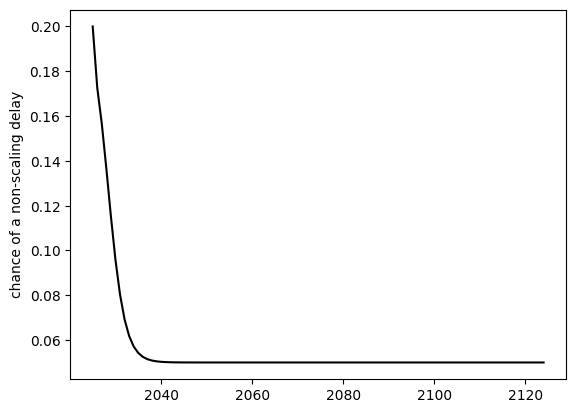

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2035 - c

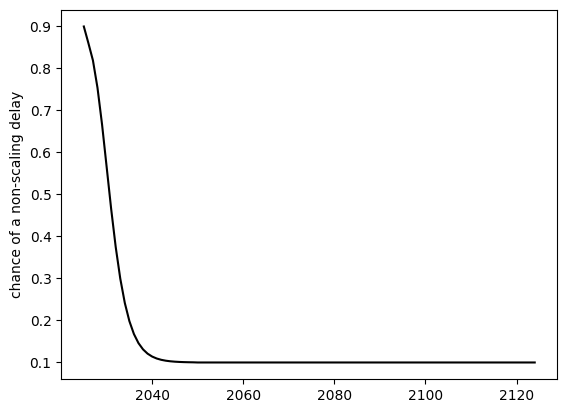

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 86%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 82%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 75%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 67%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 57%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 47%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2035

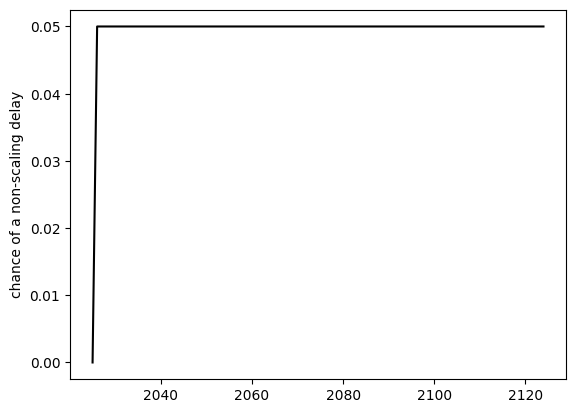

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - chance 

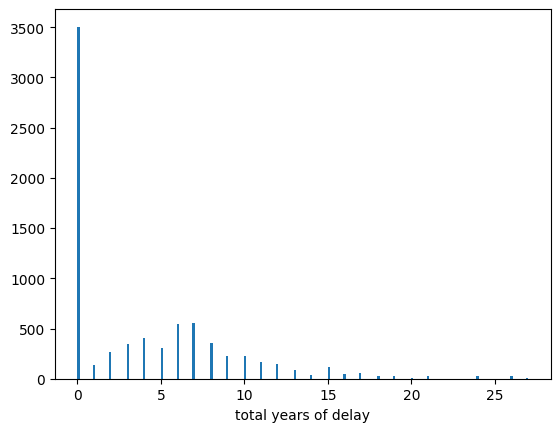

In [13]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=max(1, os.cpu_count() - 2),
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##

In this simulation:
* It takes 49.6 log FLOP (~39.8 quadrillion decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 6 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.3 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~9.4 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~366.7 million).
* This doubles every 0.3 year to a max of 0.018435% of GDP (initially ~4.6 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 49.6 logFLOP which costs 31.1 log 2025$USD to buy vs. WTP at 8.5 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 49.0 logFLOP which costs 30.4 log 2025$USD to buy vs. WTP at 9.3 (buys 27.9 log FLOP or 28.5 2025-log-eFLOP)
2027 - TAI takes 48.5 logFLOP which costs 29.7 log 2025$USD to buy vs. WTP at 9.6 (buys 28.4 log FLOP or 29.5 2025-log-eFLOP)
2028 - TAI takes 47.9 logFLOP w

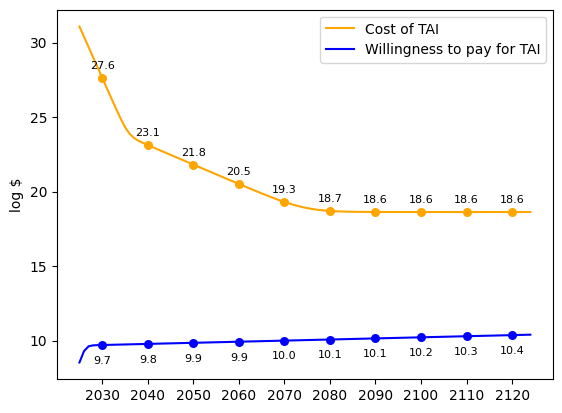

-
-
## SAMPLE RUN 5 ##

In this simulation:
* It takes 36.8 log FLOP (~6.3 thousand decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.4 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10.9 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 1.1 year to a max of 0.054511% of GDP (initially ~13.9 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 36.8 logFLOP which costs 17.8 log 2025$USD to buy vs. WTP at 9.0 (buys 28.0 log FLOP or 28.0 2025-log-eFLOP)
2026 - TAI takes 36.5 logFLOP which costs 17.4 log 2025$USD to buy vs. WTP at 9.3 (buys 28.4 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 36.3 logFLOP which costs 17.1 log 2025$USD to buy vs. WTP at 9.5 (buys 28.7 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 36.0 logFLOP which

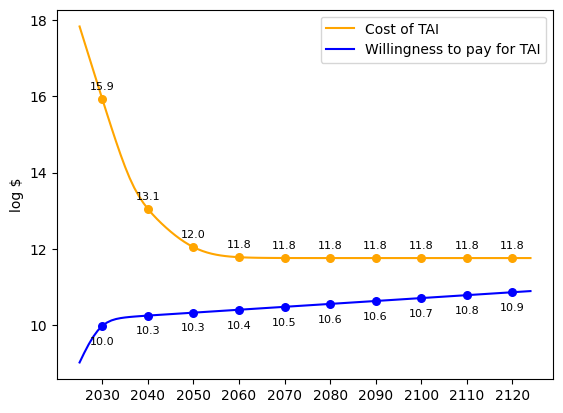

-
-
## SAMPLE RUN 6 ##

In this simulation:
* It takes 34.0 log FLOP (~10.0 decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.3 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~282.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~310.3 million).
* This doubles every 1.1 year to a max of 0.066061% of GDP (initially ~16.6 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 34.0 logFLOP which costs 15.1 log 2025$USD to buy vs. WTP at 8.5 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 33.6 logFLOP which costs 14.6 log 2025$USD to buy vs. WTP at 8.7 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 33.2 logFLOP which costs 14.1 log 2025$USD to buy vs. WTP at 9.0 (buys 28.2 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 32.9 logFLOP which cost

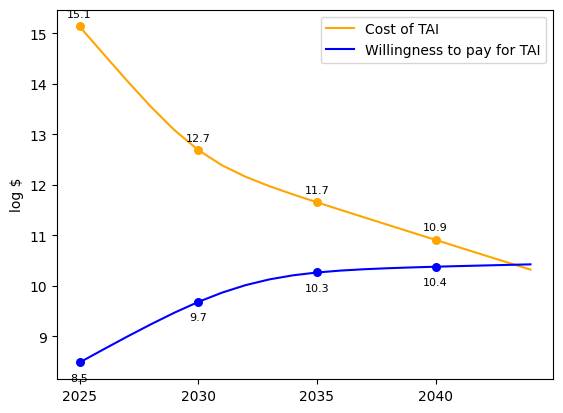

-
-
## SAMPLE RUN 7 ##

In this simulation:
* It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.1 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~11.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~777.7 million).
* This doubles every 0.8 year to a max of 0.14701% of GDP (initially ~37.1 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 26.5 logFLOP which costs 7.7 log 2025$USD to buy vs. WTP at 8.9 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 6 m

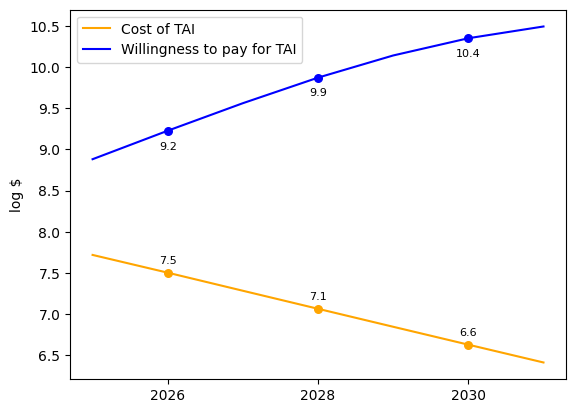

-
-
## SAMPLE RUN 8 ##

In this simulation:
* It takes 44.0 log FLOP (~100.0 billion decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.4 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~8.3 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~765.8 million).
* This doubles every 0.6 year to a max of 0.007834% of GDP (initially ~2.0 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 44.0 logFLOP which costs 25.2 log 2025$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 43.8 logFLOP which costs 24.8 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 43.5 logFLOP which costs 24.5 log 2025$USD to buy vs. WTP at 9.2 (buys 28.2 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 43.3 logFLOP whic

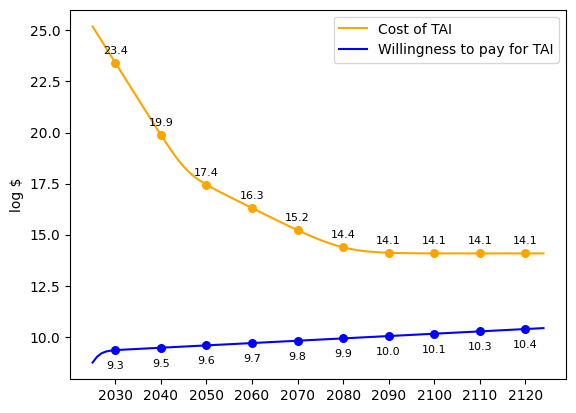

-
-
## SAMPLE RUN 9 ##

In this simulation:
* It takes 37.0 log FLOP (~10.0 thousand decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~17.2 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~47.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~742.1 million).
* This doubles every 1.3 year to a max of 0.045183% of GDP (initially ~11.3 billion 2025$USD).
* GDP grows at a rate of 1.04x per year.
---
2025 - TAI takes 37.0 logFLOP which costs 17.8 log 2025$USD to buy vs. WTP at 8.8 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 36.7 logFLOP which costs 17.4 log 2025$USD to buy vs. WTP at 9.1 (buys 28.4 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 36.4 logFLOP which costs 17.0 log 2025$USD to buy vs. WTP at 9.3 (buys 28.7 log FLOP or 29.3 2025-log-eFLOP)
2028 - TAI takes 36.2 logFLOP wh

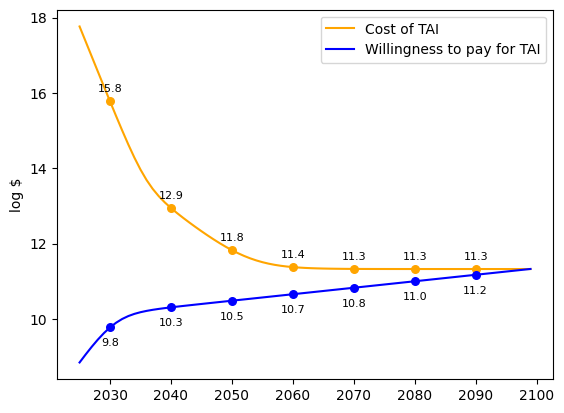

-
-
## SAMPLE RUN 10 ##

In this simulation:
* It takes 49.3 log FLOP (~20.0 quadrillion decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 6 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~16.3 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~280.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~582.9 million).
* This doubles every 1.2 year to a max of 0.008695% of GDP (initially ~2.2 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 49.3 logFLOP which costs 30.1 log 2025$USD to buy vs. WTP at 8.7 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 48.7 logFLOP which costs 29.4 log 2025$USD to buy vs. WTP at 8.9 (buys 28.2 log FLOP or 28.8 2025-log-eFLOP)
2027 - TAI takes 48.1 logFLOP which costs 28.7 log 2025$USD to buy vs. WTP at 9.0 (buys 28.4 log FLOP or 29.6 2025-log-eFLOP)
2028 - TAI takes 47.5 logFL

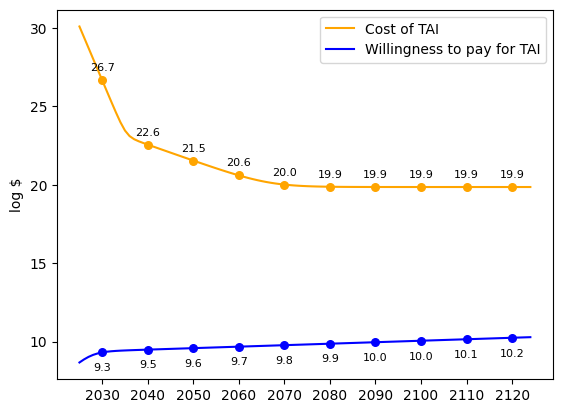

-
-
## SAMPLE RUN 11 ##

In this simulation:
* It takes 33.5 log FLOP (~3.2 decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.0 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 25.6 log FLOP (~40.0 septillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.8 billion).
* This doubles every 1.2 year to a max of 0.025571% of GDP (initially ~6.4 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 33.5 logFLOP which costs 14.6 log 2025$USD to buy vs. WTP at 9.3 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
2026 - TAI takes 33.3 logFLOP which costs 14.2 log 2025$USD to buy vs. WTP at 9.5 (buys 28.5 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 33.0 logFLOP which costs 13.9 log 2025$USD to buy vs. WTP at 9.6 (buys 28.7 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 32.8 logFLOP which costs 13

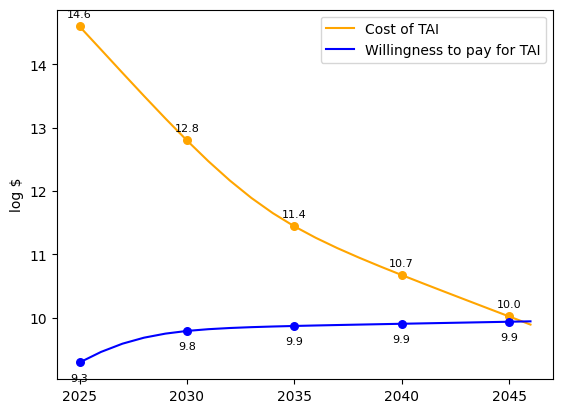

-
-
## SAMPLE RUN 12 ##

In this simulation:
* It takes 36.3 log FLOP (~2.0 thousand decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.4 quintillion) per 2025$USD.
* Every 1.9 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~51.3 sextillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.5 billion).
* This doubles every 2.4 year to a max of 7.913794% of GDP (initially ~2.0 trillion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 36.3 logFLOP which costs 17.5 log 2025$USD to buy vs. WTP at 9.4 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
2026 - TAI takes 35.9 logFLOP which costs 16.9 log 2025$USD to buy vs. WTP at 9.5 (buys 28.5 log FLOP or 28.9 2025-log-eFLOP)
2027 - TAI takes 35.4 logFLOP which costs 16.3 log 2025$USD to buy vs. WTP at 9.7 (buys 28.8 log FLOP or 29.6 2025-log-eFLOP)
2028 - TAI takes 35.0 logFLOP whic

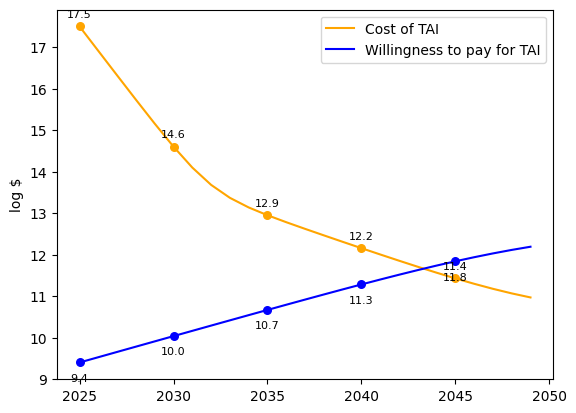

-
-
## SAMPLE RUN 13 ##

In this simulation:
* It takes 25.5 log FLOP (~31.6 septillion) for transformative capabilities.
* Every 2.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.0 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~9.2 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~960.9 million).
* This doubles every 0.9 year to a max of 0.097796% of GDP (initially ~24.6 billion 2025$USD).
* GDP grows at a rate of 1.035x per year.
---
2025 - TAI takes 25.5 logFLOP which costs 7.0 log 2025$USD to buy vs. WTP at 9.0 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 6 m

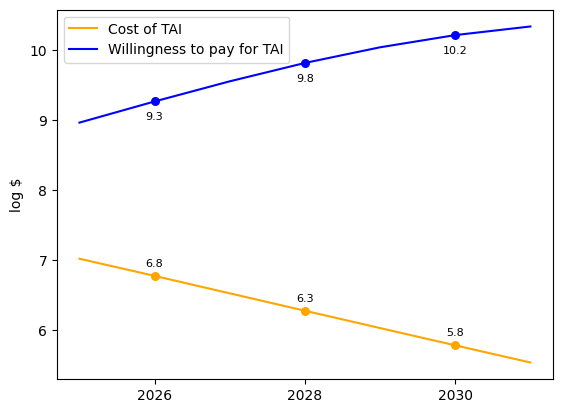

-
-
## SAMPLE RUN 14 ##

In this simulation:
* It takes 27.6 log FLOP (~4.0 octillion) for transformative capabilities.
* Every 2.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~10.6 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~14.0 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~795.4 million).
* This doubles every 0.9 year to a max of 0.006393% of GDP (initially ~1.6 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 27.6 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 8.7 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 5 mo

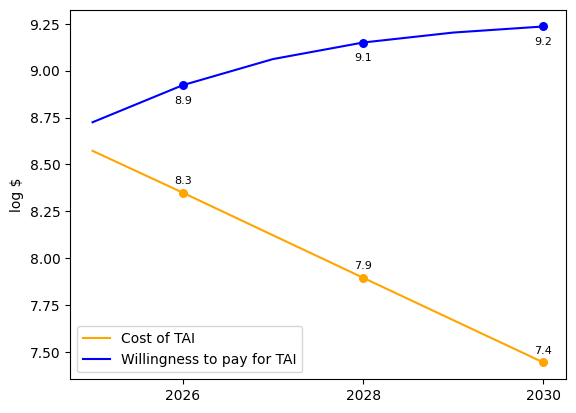

-
-
## SAMPLE RUN 15 ##

In this simulation:
* It takes 24.8 log FLOP (~6.3 septillion) for transformative capabilities.
* Every 2.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.4 log FLOP (~27.1 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~789.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~198.2 million).
* This doubles every 1.1 year to a max of 0.114152% of GDP (initially ~28.7 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 24.8 logFLOP which costs 5.4 log 2025$USD to buy vs. WTP at 8.3 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 6 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not o

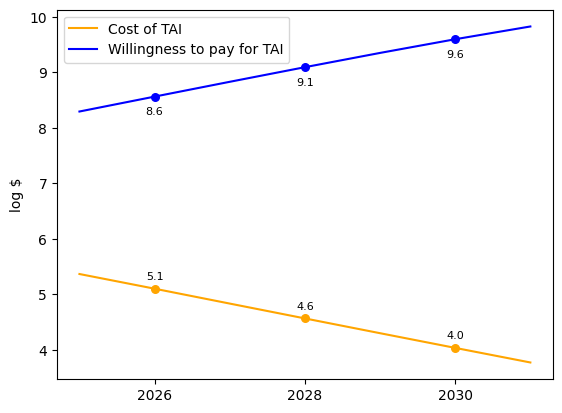

-
-
## SAMPLE RUN 16 ##

In this simulation:
* It takes 32.2 log FLOP (~158.5 nonillion) for transformative capabilities.
* Every 2.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~10.4 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 20.4 log FLOP (~232.3 quintillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~288.0 million).
* This doubles every 1.2 year to a max of 0.002679% of GDP (initially ~677.3 million 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 32.2 logFLOP which costs 13.2 log 2025$USD to buy vs. WTP at 8.3 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 32.1 logFLOP which costs 13.0 log 2025$USD to buy vs. WTP at 8.5 (buys 27.6 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 32.0 logFLOP which costs 12.7 log 2025$USD to buy vs. WTP at 8.6 (buys 27.9 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 31.9 logFLOP which

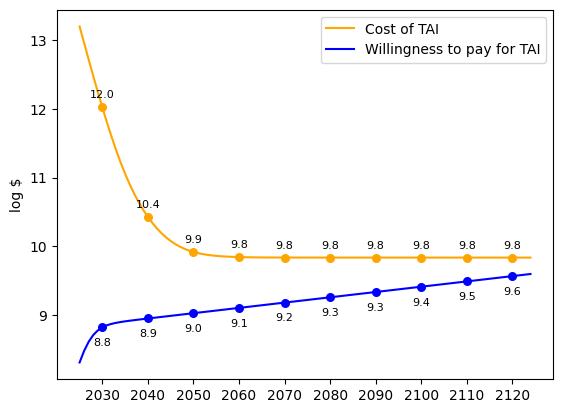

-
-
## SAMPLE RUN 17 ##

In this simulation:
* It takes 40.1 log FLOP (~12.6 million decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.8 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~188.7 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.1 billion).
* This doubles every 0.8 year to a max of 0.005012% of GDP (initially ~1.3 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 40.1 logFLOP which costs 21.4 log 2025$USD to buy vs. WTP at 8.8 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 39.7 logFLOP which costs 20.9 log 2025$USD to buy vs. WTP at 8.9 (buys 27.7 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 39.2 logFLOP which costs 20.3 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 38.8 logFLOP whic

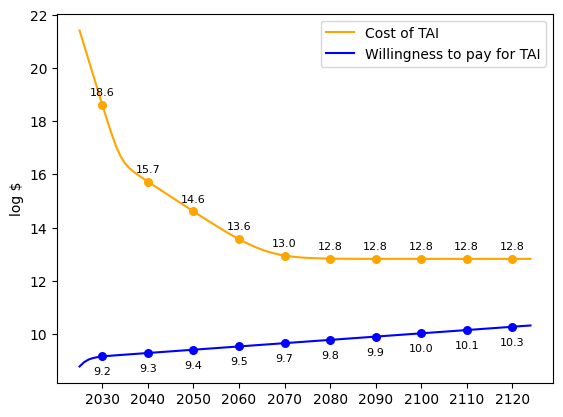

-
-
## SAMPLE RUN 18 ##

In this simulation:
* It takes 38.8 log FLOP (~631.0 thousand decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.1 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~127.4 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.0 billion).
* This doubles every 0.8 year to a max of 0.005612% of GDP (initially ~1.4 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 38.8 logFLOP which costs 20.1 log 2025$USD to buy vs. WTP at 8.8 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 38.4 logFLOP which costs 19.6 log 2025$USD to buy vs. WTP at 9.0 (buys 27.8 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 38.0 logFLOP which costs 19.1 log 2025$USD to buy vs. WTP at 9.1 (buys 28.0 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 37.7 logFLOP wh

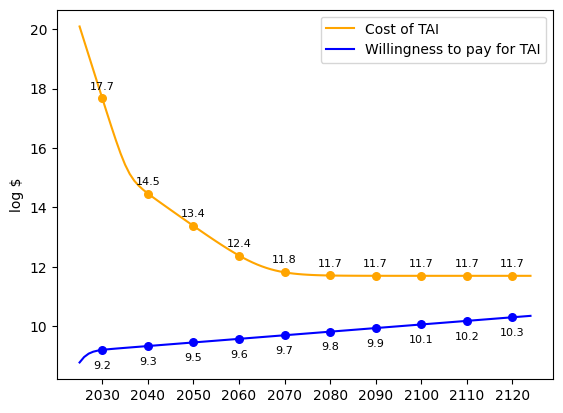

-
-
## SAMPLE RUN 19 ##

In this simulation:
* It takes 26.7 log FLOP (~501.2 septillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.5 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~5.9 septillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.1 billion).
* This doubles every 0.8 year to a max of 0.454121% of GDP (initially ~114.2 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 26.7 logFLOP which costs 7.7 log 2025$USD to buy vs. WTP at 9.5 (buys 28.5 log FLOP or 28.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 7 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occ

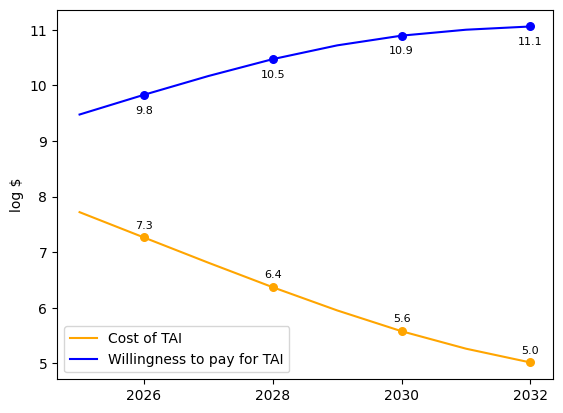

-
-
## SAMPLE RUN 20 ##

In this simulation:
* It takes 31.7 log FLOP (~50.1 nonillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.3 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~599.3 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.1 billion).
* This doubles every 0.9 year to a max of 0.033678% of GDP (initially ~8.4 billion 2025$USD).
* GDP grows at a rate of 1.012x per year.
---
2025 - TAI takes 31.7 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 9.0 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 31.5 logFLOP which costs 12.7 log 2025$USD to buy vs. WTP at 9.3 (buys 28.0 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 31.2 logFLOP which costs 12.3 log 2025$USD to buy vs. WTP at 9.5 (buys 28.4 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 31.0 logFLOP which costs 

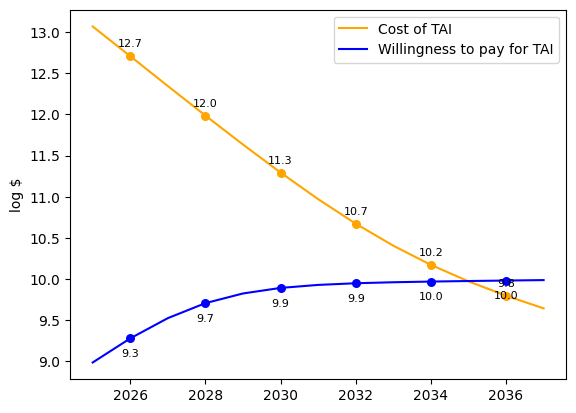

-
-
## SAMPLE RUN 21 ##

In this simulation:
* It takes 35.8 log FLOP (~631.0 decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.8 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~11.2 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~731.9 million).
* This doubles every 0.8 year to a max of 0.03729% of GDP (initially ~9.3 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 35.8 logFLOP which costs 17.1 log 2025$USD to buy vs. WTP at 8.8 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 35.5 logFLOP which costs 16.7 log 2025$USD to buy vs. WTP at 9.2 (buys 28.0 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 35.3 logFLOP which costs 16.3 log 2025$USD to buy vs. WTP at 9.4 (buys 28.4 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 35.0 logFLOP which costs

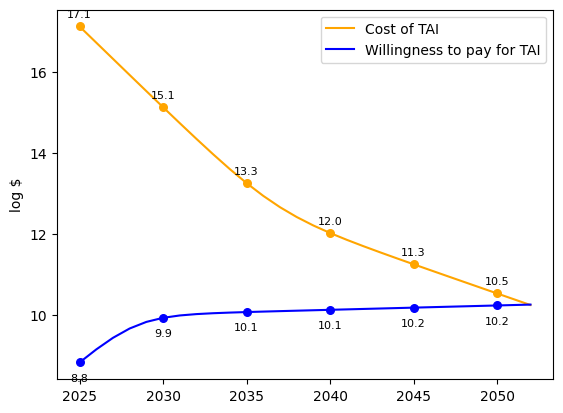

-
-
## SAMPLE RUN 22 ##

In this simulation:
* It takes 28.7 log FLOP (~50.1 octillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.4 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~59.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~311.6 million).
* This doubles every 1.0 year to a max of 0.083681% of GDP (initially ~21.1 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 28.7 logFLOP which costs 10.0 log 2025$USD to buy vs. WTP at 8.5 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 28.4 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 8.8 (buys 27.6 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 28.0 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 9.0 (buys 28.0 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 27.7 logFLOP which costs 

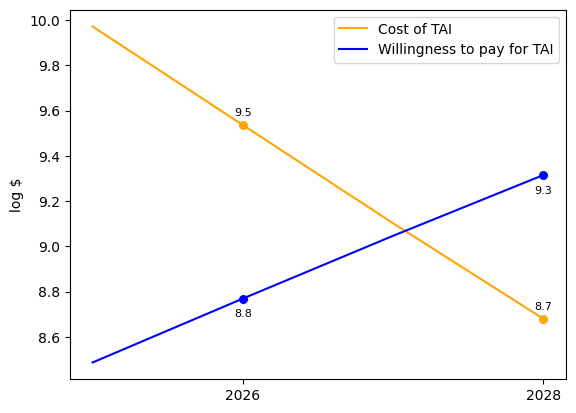

-
-
## SAMPLE RUN 23 ##

In this simulation:
* It takes 27.2 log FLOP (~1.6 octillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.3 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~119.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~314.5 million).
* This doubles every 1.1 year to a max of 0.237297% of GDP (initially ~58.9 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 27.2 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 8.5 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 27.1 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 8.8 (buys 27.3 log FLOP or 27.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1727 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8605 -> Nonscaling delay occured
-- -- this delay is 8 years

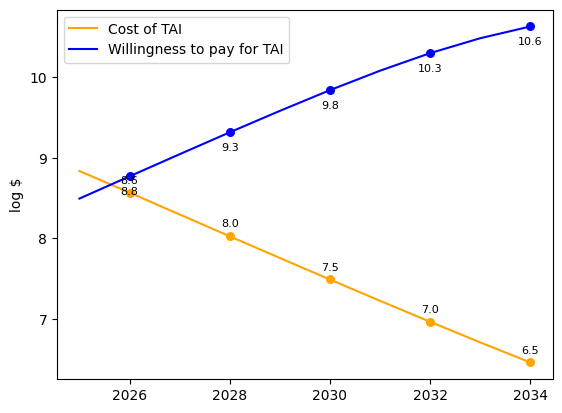

-
-
## SAMPLE RUN 24 ##

In this simulation:
* It takes 24.0 log FLOP (~1000.0 sextillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.2 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~298.5 million).
* This doubles every 0.9 year to a max of 0.021228% of GDP (initially ~5.3 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 24.0 logFLOP which costs 5.7 log 2025$USD to buy vs. WTP at 8.5 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 9 years (total delay 11 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not oc

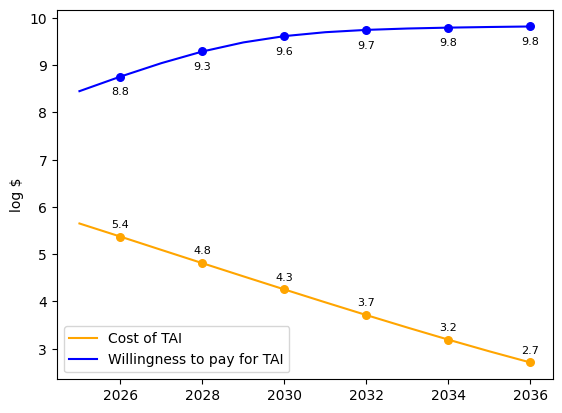

-
-
## SAMPLE RUN 25 ##

In this simulation:
* It takes 41.2 log FLOP (~158.5 million decillion) for transformative capabilities.
* Every 0.4 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.6 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~4.8 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~585.8 million).
* This doubles every 1.0 year to a max of 0.032528% of GDP (initially ~8.2 billion 2025$USD).
* GDP grows at a rate of 1.008x per year.
---
2025 - TAI takes 41.2 logFLOP which costs 22.8 log 2025$USD to buy vs. WTP at 8.7 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 40.4 logFLOP which costs 21.8 log 2025$USD to buy vs. WTP at 9.0 (buys 27.6 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 39.5 logFLOP which costs 20.8 log 2025$USD to buy vs. WTP at 9.3 (buys 28.0 log FLOP or 29.7 2025-log-eFLOP)
2028 - TAI takes 38.7 logFLOP whi

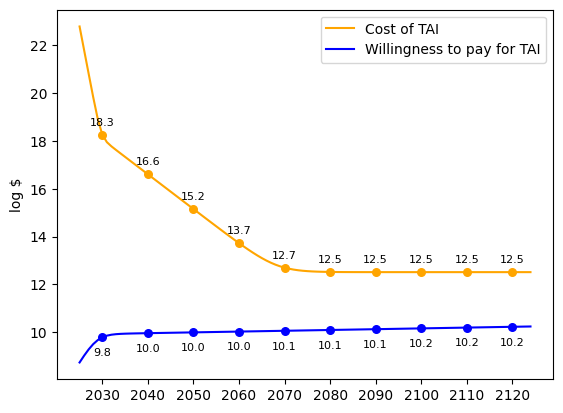

-
-
## SAMPLE RUN 26 ##

In this simulation:
* It takes 25.8 log FLOP (~63.1 septillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.7 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~12.7 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~782.9 million).
* This doubles every 0.5 year to a max of 0.214586% of GDP (initially ~54.2 billion 2025$USD).
* GDP grows at a rate of 1.035x per year.
---
2025 - TAI takes 25.8 logFLOP which costs 7.4 log 2025$USD to buy vs. WTP at 8.9 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 7 

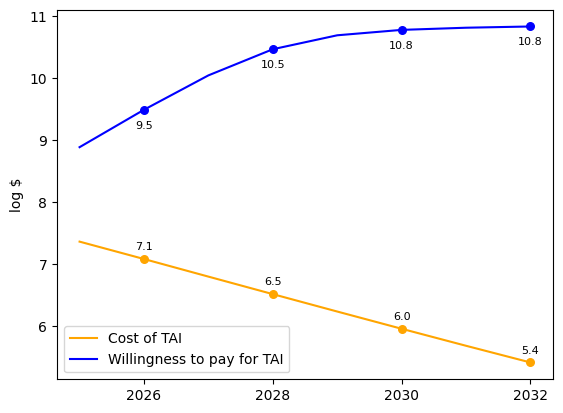

-
-
## SAMPLE RUN 27 ##

In this simulation:
* It takes 35.2 log FLOP (~158.5 decillion) for transformative capabilities.
* Every 2.3 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.1 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5.5 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~985.5 million).
* This doubles every 1.1 year to a max of 0.010424% of GDP (initially ~2.6 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 35.2 logFLOP which costs 16.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 35.1 logFLOP which costs 16.3 log 2025$USD to buy vs. WTP at 9.0 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 34.9 logFLOP which costs 16.0 log 2025$USD to buy vs. WTP at 9.2 (buys 28.1 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 34.8 logFLOP which costs

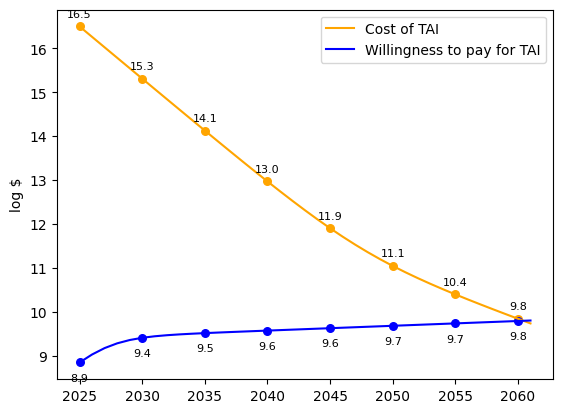

-
-
## SAMPLE RUN 28 ##

In this simulation:
* It takes 52.5 log FLOP (~31.6 quintillion decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 7 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.4 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~47.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~963.7 million).
* This doubles every 1.0 year to a max of 0.006243% of GDP (initially ~1.6 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 52.5 logFLOP which costs 33.8 log 2025$USD to buy vs. WTP at 8.8 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 52.2 logFLOP which costs 33.4 log 2025$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 52.0 logFLOP which costs 33.0 log 2025$USD to buy vs. WTP at 9.1 (buys 28.1 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 51.7 logFLOP

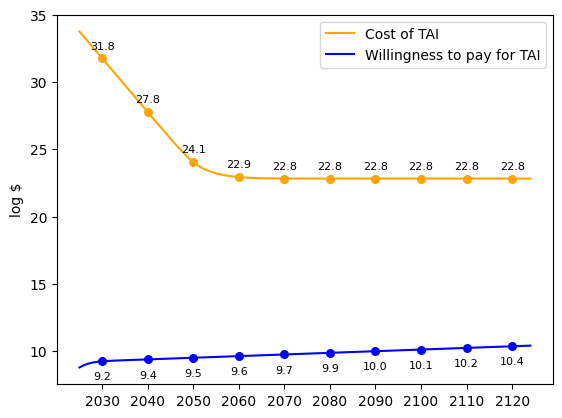

-
-
## SAMPLE RUN 29 ##

In this simulation:
* It takes 25.1 log FLOP (~12.6 septillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.8 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 25.5 log FLOP (~33.0 septillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.6 billion).
* This doubles every 0.6 year to a max of 0.309587% of GDP (initially ~77.9 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 25.1 logFLOP which costs 6.7 log 2025$USD to buy vs. WTP at 9.2 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 5 mo

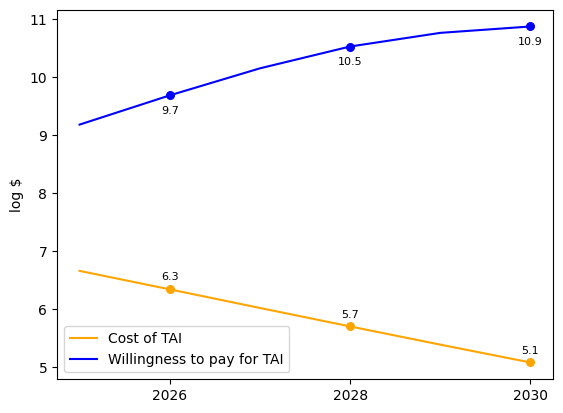

-
-
## SAMPLE RUN 30 ##

In this simulation:
* It takes 41.7 log FLOP (~501.2 million decillion) for transformative capabilities.
* Every 0.4 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~10.0 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2.6 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~789.3 million).
* This doubles every 0.6 year to a max of 0.497545% of GDP (initially ~123.7 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 41.7 logFLOP which costs 22.7 log 2025$USD to buy vs. WTP at 8.9 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 40.9 logFLOP which costs 21.8 log 2025$USD to buy vs. WTP at 9.4 (buys 28.5 log FLOP or 29.3 2025-log-eFLOP)
2027 - TAI takes 40.2 logFLOP which costs 20.9 log 2025$USD to buy vs. WTP at 9.9 (buys 29.1 log FLOP or 30.7 2025-log-eFLOP)
2028 - TAI takes 39.4 logFLOP 

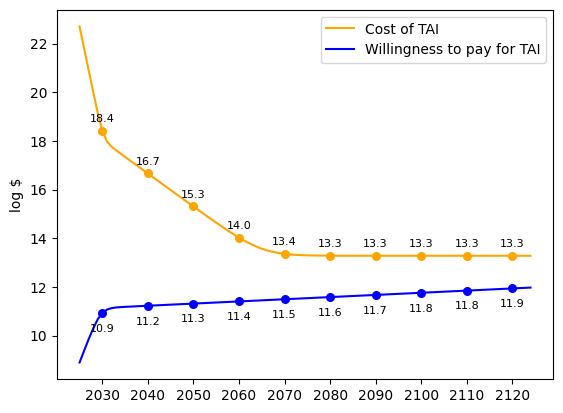

-
-
## SAMPLE RUN 31 ##

In this simulation:
* It takes 28.2 log FLOP (~15.8 octillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~5.7 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 20.4 log FLOP (~271.3 quintillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~769.9 million).
* This doubles every 0.6 year to a max of 0.100208% of GDP (initially ~25.1 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 28.2 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 28.0 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 9.3 (buys 28.2 log FLOP or 28.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1727 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8605 -> Nonscaling delay occured
-- -- this delay is 8 yea

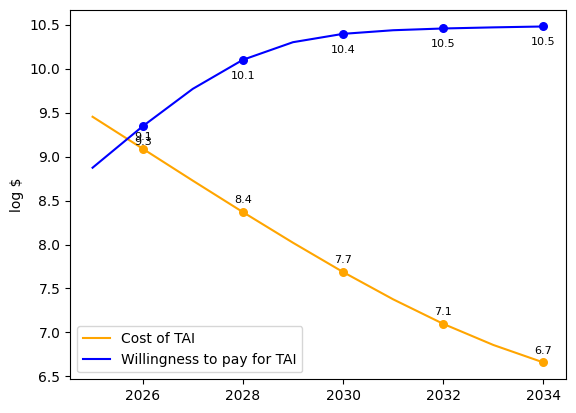

-
-
## SAMPLE RUN 32 ##

In this simulation:
* It takes 47.9 log FLOP (~794.3 trillion decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 5.3 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.8 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.4 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~496.4 million).
* This doubles every 0.7 year to a max of 0.205799% of GDP (initially ~51.5 billion 2025$USD).
* GDP grows at a rate of 1.032x per year.
---
2025 - TAI takes 47.9 logFLOP which costs 29.0 log 2025$USD to buy vs. WTP at 8.7 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 47.6 logFLOP which costs 28.6 log 2025$USD to buy vs. WTP at 9.1 (buys 28.1 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 47.4 logFLOP which costs 28.3 log 2025$USD to buy vs. WTP at 9.5 (buys 28.7 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 47.1 logFLOP

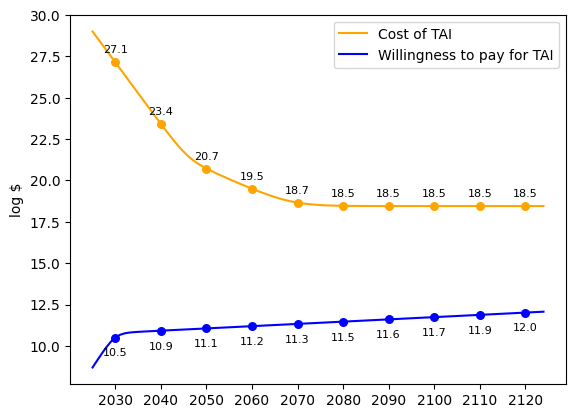

-
-
## SAMPLE RUN 33 ##

In this simulation:
* It takes 34.4 log FLOP (~25.1 decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.7 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 25.5 log FLOP (~29.2 septillion) per 2025$USD.
* We are initially willing to pay 9.9 log 2025$USD (~8.5 billion).
* This doubles every 3.0 year to a max of 0.073225% of GDP (initially ~18.3 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 34.4 logFLOP which costs 15.4 log 2025$USD to buy vs. WTP at 9.8 (buys 28.8 log FLOP or 28.8 2025-log-eFLOP)
2026 - TAI takes 34.1 logFLOP which costs 15.0 log 2025$USD to buy vs. WTP at 9.8 (buys 28.9 log FLOP or 29.3 2025-log-eFLOP)
2027 - TAI takes 33.7 logFLOP which costs 14.5 log 2025$USD to buy vs. WTP at 9.9 (buys 29.1 log FLOP or 29.8 2025-log-eFLOP)
2028 - TAI takes 33.4 logFLOP which costs 

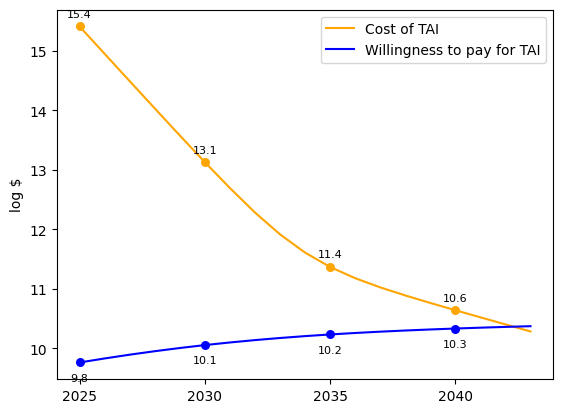

-
-
## SAMPLE RUN 34 ##

In this simulation:
* It takes 28.1 log FLOP (~12.6 octillion) for transformative capabilities.
* Every 2.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~15.5 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~410.3 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~466.0 million).
* This doubles every 0.5 year to a max of 0.026331% of GDP (initially ~6.6 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 28.1 logFLOP which costs 8.9 log 2025$USD to buy vs. WTP at 8.6 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 28.0 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 9.1 (buys 28.4 log FLOP or 28.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1727 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8605 -> Nonscaling delay occured
-- -- this delay is 8 year

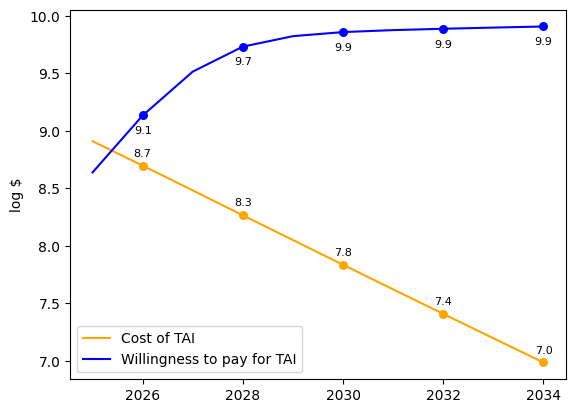

-
-
## SAMPLE RUN 35 ##

In this simulation:
* It takes 27.8 log FLOP (~6.3 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~12.9 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~968.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~249.0 million).
* This doubles every 0.5 year to a max of 0.11287% of GDP (initially ~28.3 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 27.8 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 8.4 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 27.5 logFLOP which costs 8.3 log 2025$USD to buy vs. WTP at 9.0 (buys 28.2 log FLOP or 28.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1727 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8605 -> Nonscaling delay occured
-- -- this delay is 7 years

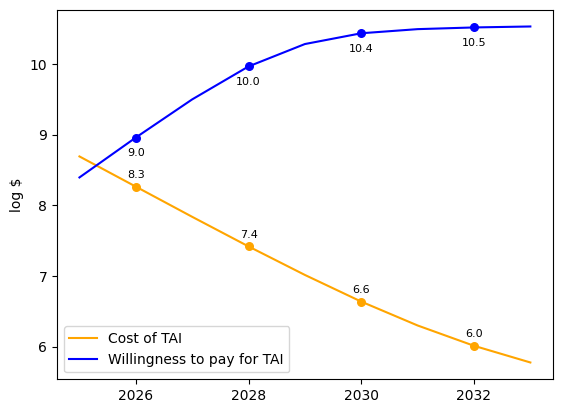

-
-
## SAMPLE RUN 36 ##

In this simulation:
* It takes 41.5 log FLOP (~316.2 million decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.6 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~5.9 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~606.5 million).
* This doubles every 1.0 year to a max of 0.062148% of GDP (initially ~15.7 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 41.5 logFLOP which costs 22.8 log 2025$USD to buy vs. WTP at 8.8 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 41.1 logFLOP which costs 22.3 log 2025$USD to buy vs. WTP at 9.1 (buys 27.8 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 40.7 logFLOP which costs 21.8 log 2025$USD to buy vs. WTP at 9.3 (buys 28.2 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 40.3 logFLOP wh

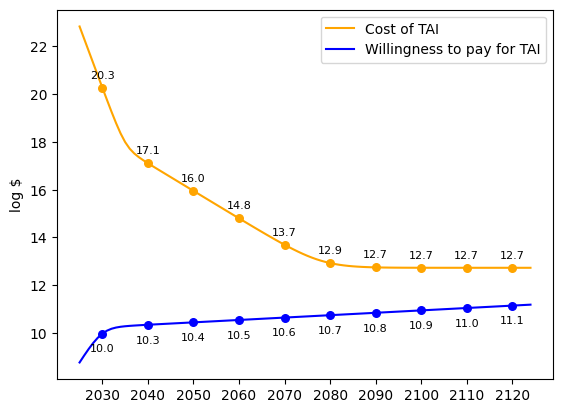

-
-
## SAMPLE RUN 37 ##

In this simulation:
* It takes 43.2 log FLOP (~15.8 billion decillion) for transformative capabilities.
* Every 2.8 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.0 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~576.1 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~953.6 million).
* This doubles every 1.3 year to a max of 0.082141% of GDP (initially ~20.6 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 43.2 logFLOP which costs 24.4 log 2025$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 43.1 logFLOP which costs 24.2 log 2025$USD to buy vs. WTP at 9.2 (buys 28.1 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 43.0 logFLOP which costs 24.0 log 2025$USD to buy vs. WTP at 9.4 (buys 28.4 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 42.9 logFLOP w

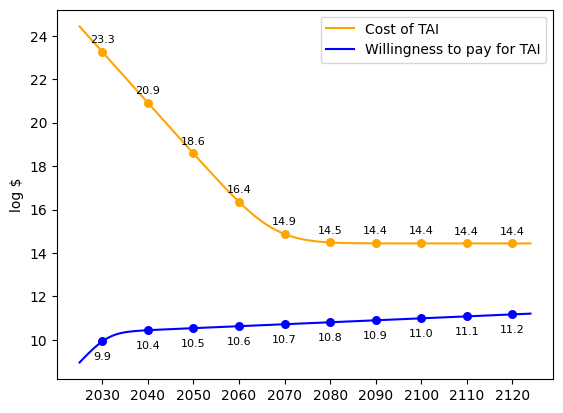

-
-
## SAMPLE RUN 38 ##

In this simulation:
* It takes 27.6 log FLOP (~4.0 octillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.2 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~156.4 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~891.8 million).
* This doubles every 1.4 year to a max of 0.012134% of GDP (initially ~3.1 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 27.6 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 8.8 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 5 mo

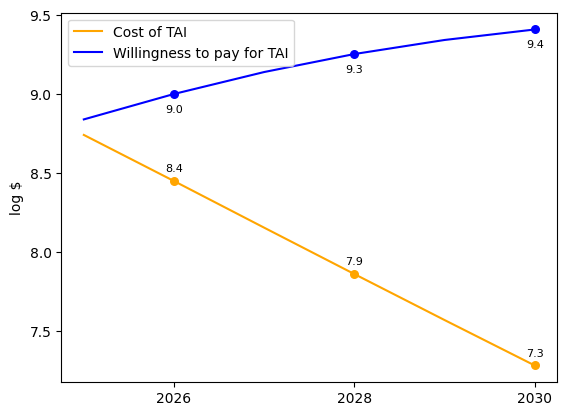

-
-
## SAMPLE RUN 39 ##

In this simulation:
* It takes 28.1 log FLOP (~12.6 octillion) for transformative capabilities.
* Every 2.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.4 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~33.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~446.8 million).
* This doubles every 2.7 year to a max of 0.016369% of GDP (initially ~4.1 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 28.1 logFLOP which costs 9.6 log 2025$USD to buy vs. WTP at 8.6 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 28.0 logFLOP which costs 9.3 log 2025$USD to buy vs. WTP at 8.7 (buys 27.4 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 27.9 logFLOP which costs 9.0 log 2025$USD to buy vs. WTP at 8.8 (buys 27.6 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 27.7 logFLOP which costs 8.

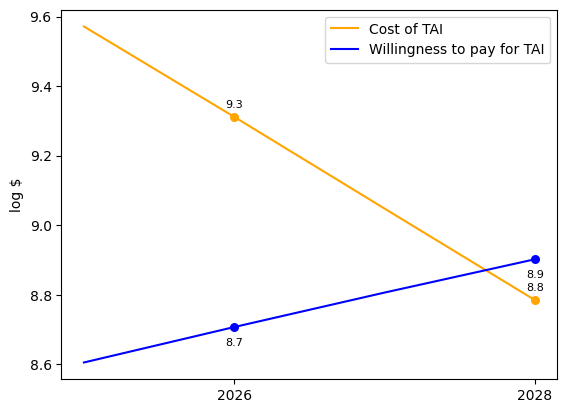

-
-
## SAMPLE RUN 40 ##

In this simulation:
* It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
* Every 2.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~16.2 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~142.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~312.9 million).
* This doubles every 1.0 year to a max of 0.120066% of GDP (initially ~30.0 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 26.5 logFLOP which costs 7.3 log 2025$USD to buy vs. WTP at 8.5 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs

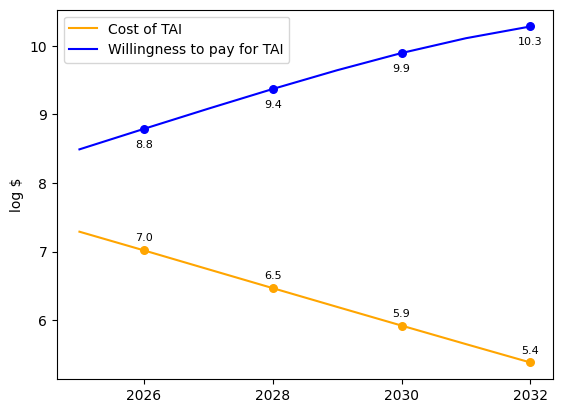

-
-
## SAMPLE RUN 41 ##

In this simulation:
* It takes 35.1 log FLOP (~125.9 decillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.8 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~11.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~962.9 million).
* This doubles every 1.3 year to a max of 0.102599% of GDP (initially ~26.0 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 35.1 logFLOP which costs 16.7 log 2025$USD to buy vs. WTP at 9.0 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 34.9 logFLOP which costs 16.3 log 2025$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 34.7 logFLOP which costs 16.0 log 2025$USD to buy vs. WTP at 9.4 (buys 28.1 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 34.5 logFLOP which cos

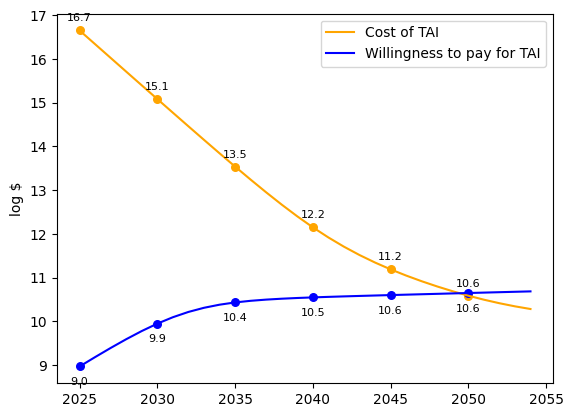

-
-
## SAMPLE RUN 42 ##

In this simulation:
* It takes 31.5 log FLOP (~31.6 nonillion) for transformative capabilities.
* Every 6.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.5 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~47.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~851.0 million).
* This doubles every 0.9 year to a max of 0.022842% of GDP (initially ~5.7 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 31.5 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 8.9 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 31.5 logFLOP which costs 13.0 log 2025$USD to buy vs. WTP at 9.2 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 31.4 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 9.4 (buys 28.0 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 31.4 logFLOP which costs

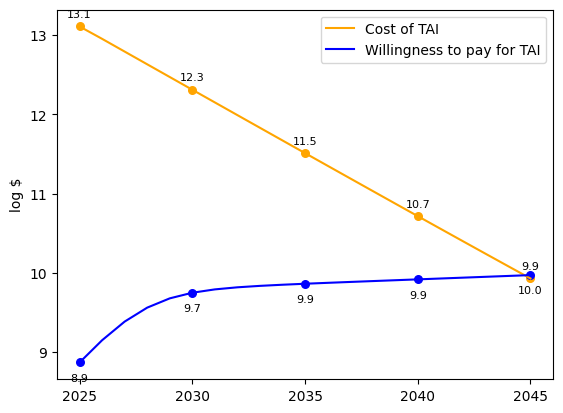

-
-
## SAMPLE RUN 43 ##

In this simulation:
* It takes 27.2 log FLOP (~1.6 octillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.3 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~92.5 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 1.1 year to a max of 0.064833% of GDP (initially ~16.2 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 27.2 logFLOP which costs 8.5 log 2025$USD to buy vs. WTP at 9.0 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 8 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
/

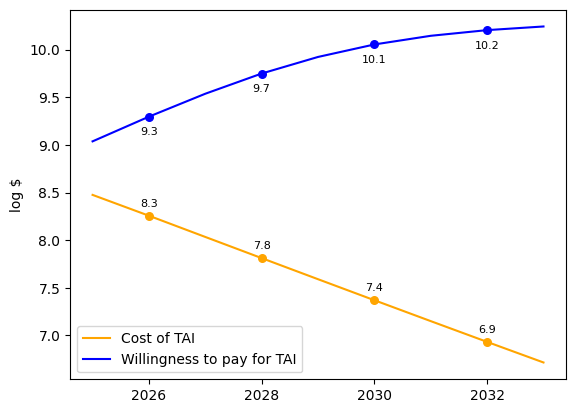

-
-
## SAMPLE RUN 44 ##

In this simulation:
* It takes 29.9 log FLOP (~794.3 octillion) for transformative capabilities.
* Every 5.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~913.9 quadrillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19.1 sextillion) per 2025$USD.
* We are initially willing to pay 9.6 log 2025$USD (~4.0 billion).
* This doubles every 0.5 year to a max of 0.082925% of GDP (initially ~20.9 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 29.9 logFLOP which costs 11.9 log 2025$USD to buy vs. WTP at 9.5 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 29.8 logFLOP which costs 11.8 log 2025$USD to buy vs. WTP at 10.0 (buys 28.0 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 29.8 logFLOP which costs 11.6 log 2025$USD to buy vs. WTP at 10.2 (buys 28.4 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 29.7 logFLOP which c

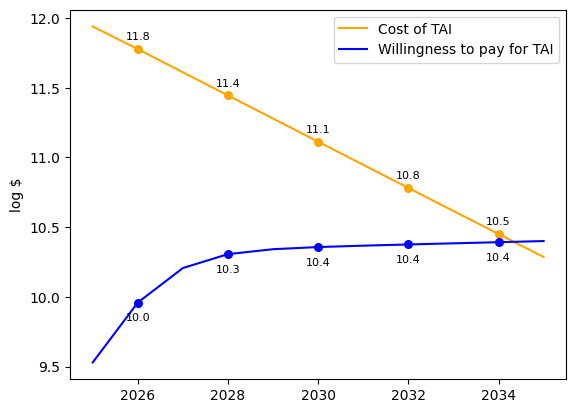

-
-
## SAMPLE RUN 45 ##

In this simulation:
* It takes 33.0 log FLOP (~1000.0 nonillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.7 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 25.6 log FLOP (~43.3 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~556.6 million).
* This doubles every 1.8 year to a max of 0.018794% of GDP (initially ~4.7 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 33.0 logFLOP which costs 14.0 log 2025$USD to buy vs. WTP at 8.7 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 32.6 logFLOP which costs 13.5 log 2025$USD to buy vs. WTP at 8.8 (buys 27.9 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 32.2 logFLOP which costs 13.0 log 2025$USD to buy vs. WTP at 9.0 (buys 28.2 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 31.9 logFLOP which cos

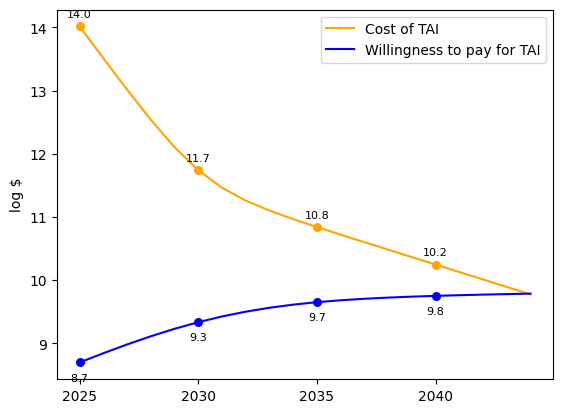

-
-
## SAMPLE RUN 46 ##

In this simulation:
* It takes 27.6 log FLOP (~4.0 octillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~2.9 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~62.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~482.7 million).
* This doubles every 1.1 year to a max of 0.052448% of GDP (initially ~13.1 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 27.6 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 8.7 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 27.5 logFLOP which costs 8.9 log 2025$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1727 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8605 -> Nonscaling delay occured
-- -- this delay is 17 years

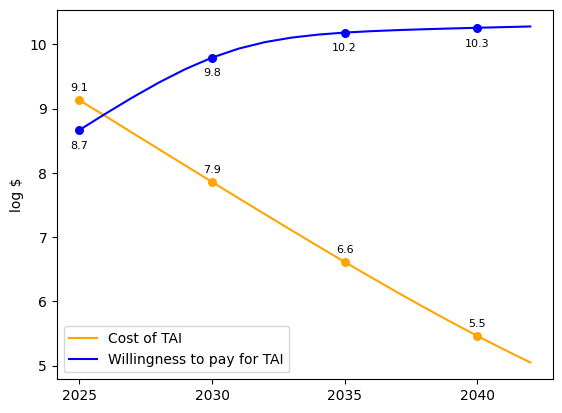

-
-
## SAMPLE RUN 47 ##

In this simulation:
* It takes 38.5 log FLOP (~316.2 thousand decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.0 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~153.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~225.7 million).
* This doubles every 0.5 year to a max of 0.001375% of GDP (initially ~351.5 million 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 38.5 logFLOP which costs 19.7 log 2025$USD to buy vs. WTP at 8.1 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 38.1 logFLOP which costs 19.2 log 2025$USD to buy vs. WTP at 8.4 (buys 27.3 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 37.7 logFLOP which costs 18.7 log 2025$USD to buy vs. WTP at 8.5 (buys 27.5 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 37.3 logFLO

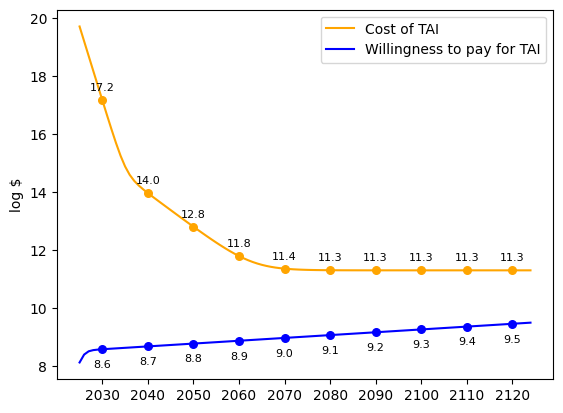

-
-
## SAMPLE RUN 48 ##

In this simulation:
* It takes 28.7 log FLOP (~50.1 octillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~18.1 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~295.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.0 log 2025$USD (~109.7 million).
* This doubles every 2.0 year to a max of 0.000603% of GDP (initially ~151.4 million 2025$USD).
* GDP grows at a rate of 1.033x per year.
---
2025 - TAI takes 28.7 logFLOP which costs 9.4 log 2025$USD to buy vs. WTP at 7.8 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 28.5 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 7.9 (buys 27.3 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 28.3 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 8.0 (buys 27.4 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 28.1 logFLOP which cost

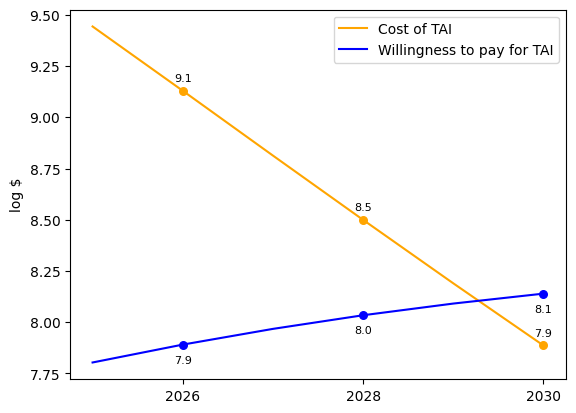

-
-
## SAMPLE RUN 49 ##

In this simulation:
* It takes 33.1 log FLOP (~1.3 decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~2.8 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~4.7 sextillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.3 billion).
* This doubles every 0.9 year to a max of 0.031416% of GDP (initially ~8.0 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 33.1 logFLOP which costs 14.6 log 2025$USD to buy vs. WTP at 9.2 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 32.8 logFLOP which costs 14.2 log 2025$USD to buy vs. WTP at 9.5 (buys 28.1 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 32.5 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 9.7 (buys 28.4 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 32.2 logFLOP which costs 13.

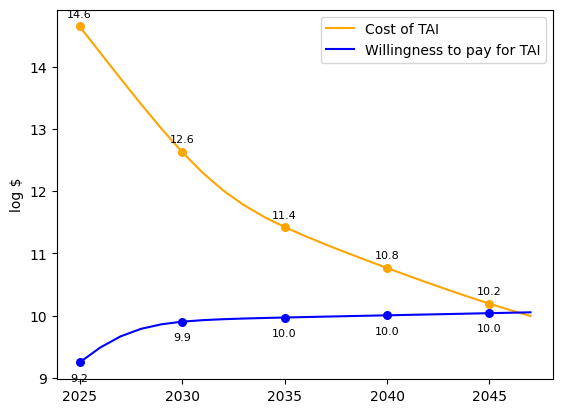

-
-
## SAMPLE RUN 50 ##

In this simulation:
* It takes 34.3 log FLOP (~20.0 decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.9 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~2.5 sextillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.8 billion).
* This doubles every 1.4 year to a max of 0.089744% of GDP (initially ~22.5 billion 2025$USD).
* GDP grows at a rate of 1.037x per year.
---
2025 - TAI takes 34.3 logFLOP which costs 15.5 log 2025$USD to buy vs. WTP at 9.2 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 33.8 logFLOP which costs 14.9 log 2025$USD to buy vs. WTP at 9.4 (buys 28.4 log FLOP or 28.8 2025-log-eFLOP)
2027 - TAI takes 33.4 logFLOP which costs 14.3 log 2025$USD to buy vs. WTP at 9.6 (buys 28.7 log FLOP or 29.6 2025-log-eFLOP)
2028 - TAI takes 32.9 logFLOP which costs 1

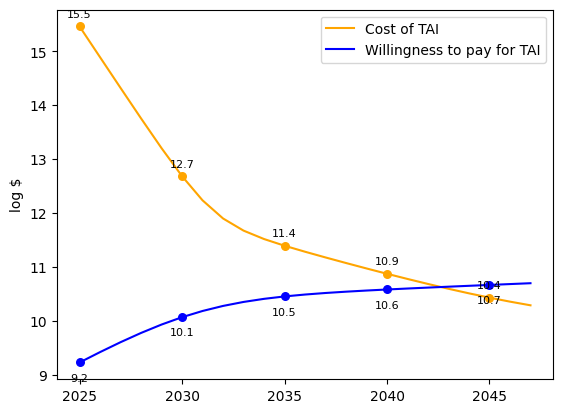

-
-
## SAMPLE RUN 51 ##

In this simulation:
* It takes 33.1 log FLOP (~1.3 decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 25.8 log FLOP (~67.0 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.1 billion).
* This doubles every 1.1 year to a max of 0.004822% of GDP (initially ~1.2 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 33.1 logFLOP which costs 14.9 log 2025$USD to buy vs. WTP at 8.8 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 32.6 logFLOP which costs 14.3 log 2025$USD to buy vs. WTP at 8.9 (buys 27.2 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 32.2 logFLOP which costs 13.7 log 2025$USD to buy vs. WTP at 9.0 (buys 27.4 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 31.8 logFLOP which costs 13

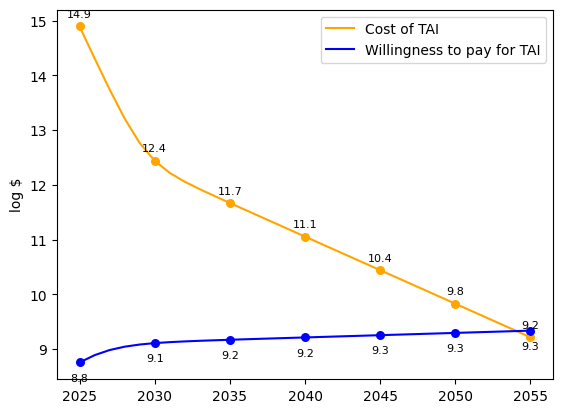

-
-
## SAMPLE RUN 52 ##

In this simulation:
* It takes 39.8 log FLOP (~6.3 million decillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.4 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~224.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~683.4 million).
* This doubles every 1.0 year to a max of 0.019616% of GDP (initially ~4.9 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 39.8 logFLOP which costs 21.2 log 2025$USD to buy vs. WTP at 8.8 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 39.7 logFLOP which costs 20.9 log 2025$USD to buy vs. WTP at 9.0 (buys 27.8 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 39.5 logFLOP which costs 20.6 log 2025$USD to buy vs. WTP at 9.3 (buys 28.1 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 39.4 logFLOP whi

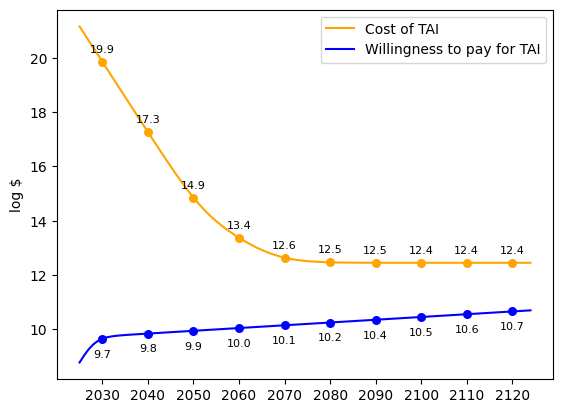

-
-
## SAMPLE RUN 53 ##

In this simulation:
* It takes 28.4 log FLOP (~25.1 octillion) for transformative capabilities.
* Every 2.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.2 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.4 septillion) per 2025$USD.
* We are initially willing to pay 10.0 log 2025$USD (~9.3 billion).
* This doubles every 0.6 year to a max of 0.555848% of GDP (initially ~140.7 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 28.4 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 9.9 (buys 28.4 log FLOP or 28.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 14 years (total delay 14 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 14 

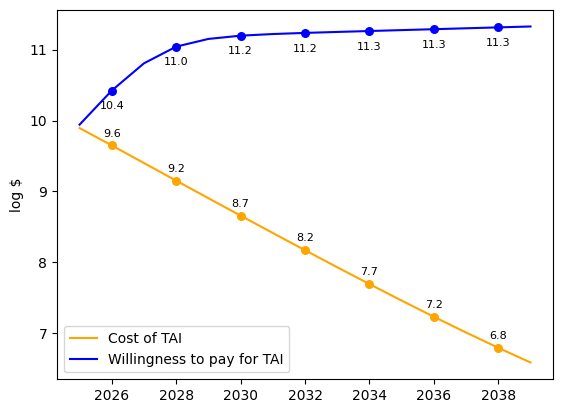

In [14]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [15]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2024-06-09 22:36:32.714228
